# Introduction

Ce projet s'inscrit dans le cadre de la formation Data Scientist dispensée par Mines Paris PSL en partenariat avec DataScientest.com.

L’objectif est de classifier des images microscopiques de différents types de cellules sanguines à l’aide d'algorithmes de Computer Vision.

## 1. Définition des paramètres

In [1]:
# Controler le chargement et la sauvegarde des datasets
LOAD_RAW = False #default = True
SAVE_RESIZED = False #default = True
LOAD_RESIZED = True #default = False
SAVE_BIN = False #default = True

# Chemin d'accès aux images brutes
path_DS_raw = './images/raw'

# Taille des images après pre-process 
img_height = 100                            #les images d'origine étant presque carrées,
img_width = 100                             #le format 100x100 offre en général un bon rapport performance/rapidité
target_size = (img_height, img_width)

# Stockage des images après resize, drop duplicates et split
path_DS_train = '../../../../Downloads/resized/train'
path_DS_valid = '../../../../Downloads/resized/valid'
path_DS_test = '../../../../Downloads/resized/test'

# Stockage des images après binarisation

    #Otsu threshold
path_DS_train_otsu = '../../../../Downloads/otsu/train'
path_DS_valid_otsu = '../../../../Downloads/otsu/valid'
path_DS_test_otsu = '../../../../Downloads/otsu/test'

    #Manual threshold
path_DS_train_bin = '../../../../Downloads/binarized/train'
path_DS_valid_bin = '../../../../Downloads/binarized/valid'
path_DS_test_bin = '../../../../Downloads/binarized/test'

## 2. Import des librairies

In [2]:
from typing import Tuple, List, Dict, Optional, Union
import time
import os
import random
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from PIL import Image
import numpy as np
import pandas as pd
pd.set_option('future.no_silent_downcasting', True) #silence a future warning
import hashlib
from tqdm import tqdm
from sklearn import ensemble
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, Binarizer
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from IPython.display import display

## 3. Définition des fonctions

In [3]:
def data_viz(path: Optional[Union[str, Path]] = None, X = None, y= None)-> Dict[str, int]:
    """
    Affiche la répartition des images par classe à partir d’un répertoire ou de deux tableaux (X et y).

    Parameters
    ----------
    path : str, optional
        Chemin vers le dossier contenant les sous-dossiers (classes).
    X : array-like, optional
        Données d’image (non utilisées, seulement requis pour cohérence avec y).
    y : array-like, optional
        Étiquettes associées aux données X.

    Returns
    -------
    Dict[str, int]
        Dictionnaire des classes et de leur nombre d’images.
    """

    start_time = time.perf_counter()
    
    if path is None and (X is None or y is None):
        raise ValueError("Path or (X and y) are missing")

    if path is not None and X is not None and y is not None:
        raise ValueError("Can't have both path and (X and y)")

    if path is not None:
        path = Path(path)  # Conversion explicite de path en Path
    
    if X is not None and y is not None:
        # comptage des images par label de y           
        counts = Counter(y)

    if path is not None:
        # comptage des images par catégores (= sous-dossier de directory)            
        
        counts = {}
    
        for subdir in path.iterdir():
            if subdir.is_dir():
                counts[subdir.name] = len(list(subdir.glob("*")))

    counts = dict(sorted(counts.items())) #tri alphabétique des clés
    
    print(sum(counts.values()), f"images found in {int(time.perf_counter()-start_time)}s, belonging to", len(counts.keys()), 'classes:', list(counts.keys()))
    
    # création de 2 graphiques
    
    plt.figure(figsize=(12, 5))
    
        # graph en barre
    
    
    
    plt.subplot(121)
    plt.bar(x=counts.keys(), height= counts.values())
    plt.xticks(rotation=70)
    plt.title("Répartition des images par classe");

    
        # camembert 
    
    labels_quantites = [f"{label}\n({val})" for label, val in counts.items()]
    
    plt.subplot(122)
    plt.pie(x = counts.values(),
          labels = labels_quantites,
          autopct = lambda x: str(round(x, 1)) + ' %',
          pctdistance = 0.7,
          labeldistance = 1.2)
    plt.title("Proportions par classe");
    
    plt.tight_layout()
    plt.show();
    
    return counts

In [4]:
def _hash_image(img: np.ndarray) -> str:
    """Créé un hash unique pour chaque image qui permet de détecter les doublons bcp plus rapidement: complexité O(n) au lieu de O(n2)"""
    return hashlib.sha256(img.tobytes()).hexdigest() 

def _drop_duplicates(X, y, names, verbose) -> Tuple[List, List[str], List[str]]:
    """Remove duplicate images from X, y and names"""

    start_time = time.perf_counter()
    
    seen_hashes ={}
    duplicates = []
    
    for i, img in enumerate(tqdm(X, desc="Checking duplicates")):
        h = _hash_image(img)
        if h not in seen_hashes:         #si le hash de l'image i est nouveau
            seen_hashes[h] = i           #on mémorise son indice i
        else:
            previous = seen_hashes[h]           # previous = indice de l'image existante
            duplicates.append((previous, i))      # l'image i est un doublon de previous

    if verbose: 
        print("ℹ️",len(duplicates), f"duplicates removed in {int(time.perf_counter()-start_time)}s") 
        #affichage des doublons après la boucle
        for n, (previous,i) in enumerate(duplicates):
            print(f"{n+1}. {y[previous]} {names[previous]} has a duplicate : {y[i]} {names[i]}")
            plt.subplot(121)
            plt.imshow(X[previous])
            plt.title(y[previous] + "\n" + names[previous])
            plt.axis(False)
            plt.subplot(122)
            plt.imshow(X[i])
            plt.title(y[i] + "\n" + names[i])
            plt.axis(False)
            plt.show();

    

    # Extraction des images uniques
    indices_to_keep = list(seen_hashes.values())
    X = [X[i] for i in indices_to_keep]
    y = [y[i] for i in indices_to_keep]
    names = [names[i] for i in indices_to_keep] 

    
    if verbose: print("✅",len(X), "images left, belonging to", len(set(y)), 'classes:', set(y))
    
    return X,y,names

In [5]:
def load_images(path, target_size=None, drop_duplicates=True, verbose=True):
    """
    using Path and PIL
    """
    start_time = time.perf_counter()
    
    X, y, names = [], [], []
    path = Path(path)

    #Load, convert to RGB, resize and convert to ndarray
    class_folders = [p for p in path.iterdir() if p.is_dir()]
    
    for class_path in tqdm(class_folders, desc=f"Loading images from {len(class_folders)} subfolders"):
        class_name = class_path.name
        for file_path in class_path.iterdir():
            try:
                with Image.open(file_path) as img:
                    img = img.convert('RGB')
                    if target_size is not None : img = img.resize(target_size)
                    arr = np.array(img)

                    X.append(arr)
                    y.append(class_name)
                    names.append(file_path.name)
            except Exception as e:
                if verbose: print(f"❌ Skipped {file_path}: {e}")

    if verbose: print("✅", len(y), f"images loaded in {int(time.perf_counter()-start_time)}s belonging to", len(set(y)), 'classes:', set(y))

    if drop_duplicates:
        X,y,names = _drop_duplicates(X,y,names,verbose)
    
    # if no resizing : compute and print number of unique sizes 
    if target_size is None:
        X_sizes = set(img.shape for img in X)    
        if verbose: print(f"ℹ️ {len(X_sizes)} unique image size(s) detected:", sorted(X_sizes))
    else:
        X_sizes = set(target_size)

    if verbose: print() # saut de ligne à la fin
    
    # if number of unique sizes = 1 : return ndarray, else return List (can't process ndarray with different sizes)
    if len(X_sizes) == 1 :
        return np.array(X), np.array(y), np.array(names) 
    else: 
        return X,y,names

In [6]:
def save_images(X: List[np.ndarray],y: List[str], output_dir: str, names: List[str] = None, overwrite: bool = False, verbose=True) -> None :
    """
    Save a list of images to disk, sorted into subfolders by their labels.
    Uses 1-bit per pixel encoding if the image is binary (0/1 or 0/255).
    
    Parameters:
        X (List[np.ndarray]): List of images.
        y (List[str]): Corresponding labels (used to create subfolders).
        output_dir (str): Directory to save images.
        names (List[str], optional): List of filenames. Auto-generated if None.
        overwrite (bool): Whether to overwrite existing files.
        verbose (bool): Whether to print progress messages.
    """

    start_time = time.perf_counter()
    
    warnings_count = 0

    # Gestion des ValueError
    if names is not None and len(names) != len(X):
        raise ValueError("Les listes 'X' et 'names' doivent avoir la même longueur")
    if len(y) != len(X):
        raise ValueError("Les listes 'X' et 'y' doivent avoir la même longueur")

    # Création de la liste names si elle n'est pas fournie
    if names is None:
        names = generate_filenames(y)
    
    # Create subfolders by label
    for label in set(y):
        subfolder = os.path.join(output_dir, label)
        try:
            os.makedirs(subfolder, exist_ok=True)
        except OSError as e:
            raise RuntimeError(f"Impossible de créer le dossier '{subfolder}': {e}")

    # Sauvegarde des images
    total = len(X)
    for idx, (img, label) in enumerate(tqdm(zip(X, y), total=total, desc = f"Writing {total} images")):
        filename = names[idx]
        image_path = os.path.join(output_dir, label, filename)

        
        # Conversion en unint8 si nécessaire
        if img.max() <= 1.0:                         #si l'image est normalisée (exemple après cv2.imread)
            img = (img * 255).copy()                 #on multiplie la valeur des pixels pour avoir un entier entre 0 et 255 (et copy pour éviter de modifier X) 
        
        img = np.clip(img,0,255).astype(np.uint8)    #on s'assure dans tous les cas que que les valeurs de pixels soient au format uint8 requis par cv2.cvtColor et cv2.imwrite
                                                     # et on clip par sécurité pour s'assurer d'avoir des valeurs entre 0 et 255 (évite des éventuelles erreurs ultérieures)

        is_binary = np.isin(img, [0, 255]).all()     # définit la binarité 

        if is_binary and img.ndim == 2:              # si c'est binaire
            # Forcer extension .png (binary images are much smaller in png than others)
            base, _ = os.path.splitext(image_path)
            image_path = base + ".png"         # on modifie image_path quelque soit l'extension initiale dans names
            if os.path.exists(image_path) and not overwrite:
                warnings_count += 1
            else:
                Image.fromarray(img).convert('1').save(image_path)
        else:
        
            if img.ndim == 3 and img.shape[2] == 3:           # image couleur (ndim = 3 et la 3ème dimmension contient 3 canaux RGB)
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)    # RGB -> BGR car X est en RGB mais imwrite prend du BGR...
            elif img.ndim == 2:                               # image niveaux de gris en 2D, OK
                pass  
            elif img.ndim == 3 and img.shape[2] == 1:         # image niveaux de gris en 3D (avec un canal singleton)
                img = img.reshape(img.shape[0], img.shape[1]) # on la reshape en 2D pour éviter un bug de imwrite
            else:
                raise ValueError(f"Format d'image inattendu : shape={img.shape}")
    
            
            # Save as standard 8-bit PNG using cv2
            if os.path.exists(image_path) and not overwrite:
                warnings_count += 1
            else:
                cv2.imwrite(image_path, img)

    if warnings_count > 0 and verbose:
        print(f"⚠️ {warnings_count} fichiers existaient déjà et n'ont pas été écrasés.")

    if verbose: print(f"✅ {len(X) - warnings_count} images written in {int(time.perf_counter()-start_time)}s in {output_dir}\n")

In [7]:
def print_class_distribution(y : List[str], name: str = "Set") -> None:
    counts = Counter(y)
    total = sum(counts.values())
    # Trouver la longueur max des noms de classes pour l'alignement
    max_len = max(len(cls) for cls in counts)
    print(f"\n=== {name} ===\t{total} images\n")
    print(f"{'Classe':<{max_len}} {'Count':>7} {'%':>7}")
    print("-" * (max_len + 16))  # longueur totale approximative du titre

    for cls, count in sorted(counts.items()):
        print(f"{cls:<{max_len}} {count:7}  {count/total:6.2%}")

In [8]:
def flatten_dataset(X):
    """Aplatie un ensemble d'images ou d’échantillons en 2D (n_samples, features).
    
    Paramètres
    ----------
    X : array-like de forme (n_samples, ...)
        Ensemble d'images ou de données multidimensionnelles.
    
    Retourne
    -------
    X_flat : ndarray de forme (n_samples, n_features)
        Données aplaties pour être utilisées dans des modèles de machine learning classiques.
    """
    X = np.asarray(X)
    return X.reshape(len(X), -1)

In [9]:
class OtsuBinarizer():
    """
    Binarizes image datasets using a fixed or Otsu threshold.

    Methods:
        fit(X):               Compute Otsu threshold on grayscale images.
        transform(X):         Apply binarization using the selected threshold.
        fit_transform(X):     Fit then transform.
        get_otsu():           Returns Otsu threshold
        show(X):              Plot intensity histogram with threshold line.

    Supports RGB, grayscale (2D/3D), and flattened (1D) images.
    """
    def __init__(self, threshold='otsu'):
        """
        Parameters:
            threshold: 'otsu' or float in [0,1]
        """
        self.threshold_param = threshold
        self.otsu_ = None
        self.threshold_ = None                                                  

    def _to_grayscale(self, X) -> np.ndarray:
        """
        Convert a batch of images (RGB, grayscale 2D/3D, or flattened 1D)
        into grayscale images:
          - flattened 1D images if input images are flattened,
          - 2D grayscale images otherwise.
        """
        X = np.asarray(X)

        if X.ndim == 2:                           # batch of flatten 1D images (n_samples, pixels)
            return X
    
        elif X.ndim == 3:                         
            if X.shape[-1] == 1:                    # batch of flattened images with a trailing 1 channel dim (n_samples, pixels, 1)
                return X.squeeze(axis=-1)
            else:
                return X                            # batch of 2D grayscale images (n_samples, H, W)
    
        elif X.ndim == 4:  
            if X.shape[-1] == 1:                  # batch of 3D grayscale images (n_samples, height, width, 1) → flatten last dim 
                return X.squeeze(axis=-1)
            elif X.shape[-1] == 3:                # batch of RGB images, convert each to grayscale 2D
                gray_images = [rgb2gray(img) for img in X]
                return np.array(gray_images)
            else:
                raise ValueError(f"Unexpected number of channels: {X.shape[-1]}")
    
        else:
            raise ValueError(f"Unexpected input array dimensions: {X.ndim}")
  
    def fit(self, X, y=None):
        """
        Compute normalized Otsu threshold from grayscale pixel intensities of X.

        Parameters:
            X : array-like
                Batch of images (RGB, grayscale, or flattened) with shape 
                (n_samples, ...) and pixel values in [0,255] or [0,1].
            y: Ignored (scikit-learn convention)
    
        Returns:
            self
        """

        X = np.asarray(X)
        
        # Accept 2D, 3D or 4D datasets
        if X.ndim not in [2, 3, 4]:
            raise ValueError(f"Expected 2D, 3D or 4D array, got {X.ndim}D array instead.")

        if X.min() < 0:
            raise ValueError("Pixel values contain negatives, please check data preprocessing.")

        if X.max()>1:                                  
            X = X/255.0                                # Normalize pixels to [0,1]

        # Compute Otsu threshold
        X_gray = self._to_grayscale(X)                 #2D or 3D
        if X_gray.ndim > 2:
            X_gray = X_gray.reshape(len(X_gray), -1)   # flatten to 2D

        all_pixels = np.concatenate(X_gray)            # concatenate pixels to 1D

        self.otsu_ = threshold_otsu(all_pixels)
        
        if self.threshold_param == 'otsu':
            self.threshold_ = self.otsu_
        else :
            self.threshold_ = self.threshold_param
        
        print(f"ℹ️ Otsu threshold = {self.otsu_}")
 
        return self

    def transform(self, X):
        """
        Binarize a batch of images using the stored threshold.

        Parameters:
            X : array-like
                Batch of images (RGB, grayscale, or flattened) with pixel values in [0, 255] or [0, 1].
    
        Returns:
            np.ndarray
                Binarized images with pixel values 0 or 1.
        """

        # Vérifie que fit a été executé avant transform
        if self.threshold_ is None:
            raise RuntimeError("You must fit the transformer before calling transform")

        X = np.asarray(X)
        
        # Accept 2D, 3D or 4D datasets
        if X.ndim not in [2, 3, 4]:
            raise ValueError(f"Expected 2D, 3D or 4D array, got {X.ndim}D array instead.")

        if X.min() < 0:
            raise ValueError("Pixel values contain negatives, please check data preprocessing.")

        if X.max()>1:                                  # normalise si besoin pour être compatible avec le seuil entre 0 et 1
            X = X/255.0

        X_gray = self._to_grayscale(X) 
        
        X_bin = (X_gray > self.threshold_ ).astype(np.uint8)         #Binarise selon le seuil : pixels 0 ou 1                        
                                  
        return X_bin

    def fit_transform(self, X, y=None):
        """
        Fit to data, then transform it.
    
        Parameters:
            X : array-like
                Batch of images to binarize.
            y: Ignored (scikit-learn convention)
    
        Returns:
            np.ndarray
                Binarized images as uint8 arrays (0 or 1).
        """
        
        return self.fit(X, y).transform(X)

    def get_otsu(self):
        """
        Return the Otsu threshold computed from the dataset during fit,
        regardless of whether it was used for binarization.
    
        Returns:
            float: Otsu threshold value.
        """
        if self.otsu_ is None:
            raise RuntimeError("Otsu threshold is not available. You must fit the transformer first.")
        return self.otsu_
    
    def show_histogram(self, X):
        """
        Display intensity histogram with both Otsu and chosen thresholds.
    
        Parameters:
            X : array-like
                Batch of images (RGB, grayscale, or flattened).
        """
        
        if self.otsu_ is None:
            raise RuntimeError("You must fit the transformer before calling show")

        X = np.asarray(X)

        # Accept 2D, 3D or 4D datasets
        if X.ndim not in [2, 3, 4]:
            raise ValueError(f"Expected 2D, 3D or 4D array, got {X.ndim}D array instead.")

        X_gray = self._to_grayscale(X)
        if X_gray.ndim > 2:
            X_gray = X_gray.reshape(len(X_gray), -1)
        
        all_pixels = np.concatenate(X_gray)                           # 1D array
    
        plt.figure(figsize=(8, 4))
        plt.hist(all_pixels, bins=256, color='gray', alpha=0.7)

        # Always show Otsu threshold line in blue
        plt.axvline(self.otsu_, color='blue', linestyle='--', label=f"Otsu threshold = {self.otsu_:.4f}")        
        
        # If a custom threshold, show it too in red
        if self.threshold_param != 'otsu':
            plt.axvline(self.threshold_, color='red', linestyle='--', label=f"Threshold = {self.threshold_}")


        plt.legend()
    
        plt.title("Image intensity histogram")
        plt.xlabel("Intensity")
        plt.ylabel("Pixel count")
        plt.tight_layout()
        plt.show()

    def show_samples(self, X, y=None, names = None, n_samples: int = 7):

        if self.otsu_ is None:
            raise RuntimeError("You must fit the transformer before calling show")

        X = np.asarray(X)

        # Accept 2D, 3D or 4D datasets
        if X.ndim not in [2, 3, 4]:
            raise ValueError(f"Expected 2D, 3D or 4D array, got {X.ndim}D array instead.")

        # Tirer 5 indices au hasard
        indices = random.sample(range(len(X)), n_samples)
        
        X_bin = self.transform(X[indices])
        
        fig, axs = plt.subplots(2, n_samples, figsize=(15, 6))
        
        for i, idx in enumerate(indices):
                       
            axs[0, i].imshow(X[idx])
            axs[0, i].axis('off')
            title = f"Original #{idx}"
            if y is not None : title += f"\n{y[idx]}"
            if names is not None : title += f"\n{names[idx]}"
            axs[0, i].set_title(title)
        
            axs[1, i].imshow(X_bin[i], cmap='gray', vmin=0, vmax=1)
            axs[1, i].axis('off')
            axs[1, i].set_title(f'{self.threshold_param}')

        plt.tight_layout()
        plt.show()

In [10]:
def evaluate_ML_global(models, datasets, verbose : bool = True) -> pd.DataFrame:

    global_start_time = time.perf_counter()
    
    #paramètres pour tous les modèles : standardization et encoding (pour homognéiser le fit et predict même si ce n'est pas idéal)
    scale = True       #Tree-base models doesn't need scaling (RF, XGB, CAT, LGB). NB: KNN may work better with normalization instead of standardization
    encode = True      #encoding is mandatory only for XGB

    global_perf = None
    
    for dataset in datasets:
        
        X_train, X_valid, y_train, y_valid, dataset_name = dataset

        if verbose: print("===", dataset_name, "===\n")
        
        # Flatten une seule fois pour chaque dataset puis flatten = False sur tous les appels suivant (pour gagner en perf)
        X_train_flat = np.asarray(X_train).reshape(len(X_train), -1)
        X_valid_flat = np.asarray(X_valid).reshape(len(X_valid), -1)
        flatten = False

        dataset_models = []
        dataset_accuracies = []
        dataset_durations = []
        
        for model in models:

            start_time = time.perf_counter()
            accuracy, _ = evaluate_ML_model(model, X_train_flat, X_valid_flat, y_train, y_valid, flatten, scale, encode, verbose)
            end_time = time.perf_counter()         
            
            duration = round(end_time - start_time,3)  
            dataset_models.append(model.__class__.__name__)
            dataset_accuracies.append(accuracy)
            dataset_durations.append(duration)

        dataset_perf = pd.DataFrame({
        "Model": dataset_models,
        "Accuracy": dataset_accuracies,
        "Duration (s)": dataset_durations
        }).set_index("Model")

        dataset_perf.columns = pd.MultiIndex.from_product([[dataset_name], dataset_perf.columns])
        
        if verbose: display(dataset_perf)

        #concatenate dataset_perf dataframes
        if global_perf is None:
            global_perf = dataset_perf
        else:
            global_perf = pd.concat([global_perf, dataset_perf], axis=1) 


    # Add Row Mean
    global_perf.loc["📊 Average"] = global_perf.mean(numeric_only=True)

    # Add Col Mean
    
        # Sélection des colonnes paires et impaires (par position)
    cols_paires = global_perf.columns[::2]
    cols_impaires = global_perf.columns[1::2]
    
        # Calcul des moyennes par ligne
    mean_accuracy = global_perf[cols_paires].mean(axis=1)
    mean_duration = global_perf[cols_impaires].mean(axis=1)
    
        # Création des nouvelles colonnes sous forme de DataFrame avec MultiIndex colonnes
    new_cols = pd.DataFrame(
        {('📊 Average', 'Accuracy'): mean_accuracy,
         ('📊 Average', 'Duration (s)'): mean_duration},
        index=global_perf.index)
    
        # Concaténation à droite
    global_perf = pd.concat([global_perf, new_cols], axis=1)

    # Arrondi selon colonne accuracy ou duration 
    for idx, col in enumerate(global_perf.columns):
        if idx%2==0:
            global_perf[col] = global_perf[col].round(3)                     #accuracy
        else:
            global_perf[col] = global_perf[col].round(0).astype('Int64')     #duration
    
    # Remplace les NaN par des ✖️        
    global_perf = global_perf.astype(object).fillna('✖️').infer_objects(copy=False)
    
    if verbose:
        print("=== GLOBAL ===\n")
        global_end_time = time.perf_counter()         
        duration = int(global_end_time - global_start_time) 
        print(f"{len(models)} models evaluated on {len(datasets)} datasets in {duration} s\n")
        display(global_perf)
    
    return global_perf

In [11]:
def evaluate_ML_model(clf, X_train, X_valid, y_train, y_valid, flatten : bool = True, scale: bool = True, encode: bool = None, verbose : bool = True) -> float:
    
    """
    Fonction d’évaluation pour modèles classiques de ML (SVM, KNN, RF, XGBoost).
    Ne convient pas pour modèles deep learning.

    NB: Standardization (StandardScaler) is preferred for models sensitive to variance (e.g., SVM). 
        Tree-based models (e.g., RandomForest, XGBoost) do not require any scaling.
    
    Parameters
    ----------
    clf : Classifieur scikit-learn-compatible
    X_train, X_valid : array-like
        Données d'entraînement et de validation (images)
    y_train, y_valid : array-like
        Labels correspondants
    flatten : bool (True par défaut)
        Applique un reshape en 2D des ensembles X_train et X_valid
    scale : bool (True par défaut)
        Applique un StandardScaler
    encode : bool (False par défaut)
        Encode y_train et y_valid et retourne l'encoder
    verbose : bool (False par défaut)
        Affiche accuracy_score, la matrice de confusion croisée et le classification_report

    Returns
    -------
    float : accuracy_score
    """

    if flatten:
        X_train_flat = np.asarray(X_train).reshape(len(X_train), -1)
        X_valid_flat = np.asarray(X_valid).reshape(len(X_valid), -1)
    else:
        X_train_flat = np.asarray(X_train)
        X_valid_flat = np.asarray(X_valid)

    if scale:                                                 #toujours scale                                   
        scaler = StandardScaler()                             #NB1 : tree-based (RandomForest, XGBoost…) n’ont pas besoin de scaling mais le scaling est inoffensig
        X_train_flat = scaler.fit_transform(X_train_flat)     #NB2 : KNN peut fonctionner mieux avec une normalisation (MinMaxScaler) plutôt que standardisation...
        X_valid_flat = scaler.transform(X_valid_flat)
    
    if encode:
        encoder = LabelEncoder()
        y_train = encoder.fit_transform(y_train)
        # pas besoin d'encoder y_valid car y_pred sera inverse_transform
       
    if verbose: 
        print(clf)
        start_time = time.perf_counter()       # start timing prediction

    clf.fit(X_train_flat, y_train)
    
    y_pred = clf.predict(X_valid_flat)

    if encode:
        y_pred = encoder.inverse_transform(y_pred)
    
    accuracy = accuracy_score(y_valid, y_pred)

    if verbose:
        print('accuracy:', accuracy)
        end_time = time.perf_counter()         # end timing
        predict_time = end_time - start_time   # durée en secondes
        print(f'duration: {predict_time:.3f} s\n')
        display(pd.crosstab(y_valid, y_pred))
        print(classification_report(y_valid, y_pred))
    
    return (accuracy, encoder) if encode else accuracy

In [12]:
# CAN BE DELETED

def compute_acc(X_train, X_valid, y_train, y_valid,clf,flatten,scale,encode, verbose,accuracies, durations):
        start_time = time.perf_counter()
        if encode:
            acc, _ = get_ML_acc(clf=clf, X_train = X_train, X_valid=X_valid, y_train=y_train, y_valid=y_valid, flatten = flatten, scale = scale, encode = encode, verbose = verbose)
        else:
            acc = get_ML_acc(clf=clf, X_train = X_train, X_valid=X_valid, y_train=y_train, y_valid=y_valid, flatten = flatten, scale = scale, encode = encode, verbose = verbose)
        end_time = time.perf_counter()         
        dur = round(end_time - start_time,3)   
        accuracies.append(acc)
        durations.append(dur)
        return accuracies, durations
    

def get_all_ML_acc(X_train, X_valid, y_train, y_valid, RF : bool = True, SVM : bool = True, KNN : bool = True, XGB : bool = True, CAT : bool = True, LGB : bool = True, verbose : bool = True, n_jobs:int = -1, random_state:int = None) -> pd.DataFrame:

    classifiers = []
    accuracies = []
    durations = []
    
    # Flatten une seule fois ici puis flatten = False sur tous les appels suivant pour gagner en perf...
    X_train_flat = np.asarray(X_train).reshape(len(X_train), -1)
    X_valid_flat = np.asarray(X_valid).reshape(len(X_valid), -1)
    flatten = False
    
    if RF:
        #ni scale ni encode
        classifiers.append("Random Forest")
        clf = ensemble.RandomForestClassifier(n_jobs=n_jobs, random_state=random_state)
        scale = False
        encode = False
        accuracies, durations = compute_acc(X_train_flat, X_valid_flat, y_train, y_valid,clf,flatten,scale,encode,verbose,accuracies,durations)
    
    if SVM:
        #standardisation obligatoire
        classifiers.append("Support Vector Machine")
        clf = SVC(random_state=random_state) # le paramètre n_jobs n'existe pas dans SVC car il utilise un seul cœur CPU
        scale = True
        encode = False
        accuracies, durations = compute_acc(X_train_flat, X_valid_flat, y_train, y_valid,clf,flatten,scale,encode,verbose,accuracies,durations)

    
    if KNN:
        #normalisation recommandée mais on standardise...
        classifiers.append("k-Nearest Neighbors")
        clf = KNeighborsClassifier(n_jobs = n_jobs)   #le paramètre random_state n'existe pas dans KNN car c’est un algorithme non probabiliste et déterministe
        scale = True
        encode = False
        accuracies, durations = compute_acc(X_train_flat, X_valid_flat, y_train, y_valid,clf,flatten,scale,encode,verbose,accuracies,durations)
    
    if XGB:
        #encodage obligatoire
        classifiers.append("XGBoost")
        clf = XGBClassifier(
            num_class=len(set(y_train)),   # nombre de classes
            objective='multi:softmax',     # pour la classification multi-classes
            n_estimators=50,               # par défaut = 100
            n_jobs = n_jobs,
            random_state=random_state)
        scale = False
        encode = True
        accuracies, durations = compute_acc(X_train_flat, X_valid_flat, y_train, y_valid,clf,flatten,scale,encode,verbose,accuracies,durations)

    if CAT:
        classifiers.append("CatBoost")
        clf = CatBoostClassifier(
            iterations=50,                # par défaut = 1000
            thread_count= n_jobs,
            random_seed=random_state)
        scale = False
        encode = False
        accuracies, durations = compute_acc(X_train_flat, X_valid_flat, y_train, y_valid,clf,flatten,scale,encode,verbose,accuracies,durations)

    if LGB:
        classifiers.append("LightGBM")
        clf = LGBMClassifier(
            n_estimators=50,              # par défaut = 100
            objective = 'multiclass',
            n_jobs=n_jobs,
            random_state=random_state)
        scale = False
        encode = False
        accuracies, durations = compute_acc(X_train_flat, X_valid_flat, y_train, y_valid,clf,flatten,scale,encode,verbose,accuracies,durations)
    
    #Bilan
    
    result = pd.DataFrame({
        "Classifier": classifiers,
        "Accuracy": accuracies,
        "Duration (s)": durations
    }).set_index("Classifier")
    
    if verbose: display(result)
    
    return result

# I. Data Visualisation

17222 images found in 0s, belonging to 9 classes: ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphoblast', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


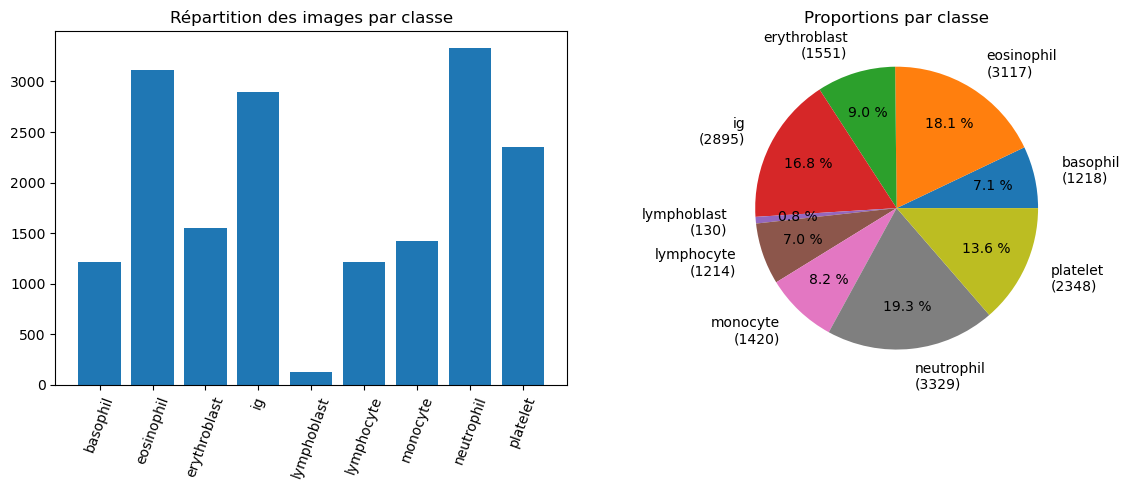

{'basophil': 1218,
 'eosinophil': 3117,
 'erythroblast': 1551,
 'ig': 2895,
 'lymphoblast': 130,
 'lymphocyte': 1214,
 'monocyte': 1420,
 'neutrophil': 3329,
 'platelet': 2348}

In [13]:
data_viz(path = path_DS_raw)

# II. Loading images and Splitting datasets

## 1. Load images
with resizing and removing duplicates

In [14]:
if LOAD_RAW:
    X,y,names = load_images(path_DS_raw, target_size=target_size, drop_duplicates = True, verbose = False)

## 2. Stratified Split
into 3 datasets : train (70%), valid (15%) and test (15%)
with stratify on labels y to keep proportions of each class

In [15]:
if LOAD_RAW:

    # 1. Train (70%) vs Temp (30%)
    X_train, X_temp, y_train, y_temp, names_train, names_temp = train_test_split(
        X, y, names, test_size=0.3, stratify=y, random_state=42)
    
    # 2. Temp (30%) → Valid (15%) + Test (15%)
    X_valid, X_test, y_valid, y_test, names_valid, names_test = train_test_split(
        X_temp, y_temp, names_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [16]:
if LOAD_RAW:
    # check class distribution after split
    print_class_distribution(y_train, "Train")
    print_class_distribution(y_valid, "Valid")
    print_class_distribution(y_test, "Test")
    print("\nTotal:", len(y_train)+len(y_valid)+len(y_test), "images")

## 3. Optional save or reload splitted datasets

In [17]:
if SAVE_RESIZED:
    save_images(X_train,y_train, output_dir = path_DS_train, names = names_train, overwrite= False)
    save_images(X_valid,y_valid, output_dir = path_DS_valid, names = names_valid, overwrite= False)
    save_images(X_test,y_test, output_dir = path_DS_test, names = names_test, overwrite= False)

In [18]:
if LOAD_RESIZED:
    X_train, y_train, names_train = load_images(path_DS_train)
    X_valid, y_valid, names_valid = load_images(path_DS_valid) 
    X_test, y_test, names_test = load_images(path_DS_test) 

Loading images from 9 subfolders: 100%|███████████| 9/9 [00:05<00:00,  1.53it/s]


✅ 12042 images loaded in 5s belonging to 9 classes: {'lymphocyte', 'lymphoblast', 'ig', 'monocyte', 'platelet', 'eosinophil', 'erythroblast', 'neutrophil', 'basophil'}


Checking duplicates: 100%|█████████████| 12042/12042 [00:00<00:00, 69095.07it/s]


ℹ️ 0 duplicates removed in 0s
✅ 12042 images left, belonging to 9 classes: {'lymphocyte', 'lymphoblast', 'ig', 'monocyte', 'platelet', 'eosinophil', 'erythroblast', 'neutrophil', 'basophil'}
ℹ️ 1 unique image size(s) detected: [(100, 100, 3)]



Loading images from 9 subfolders: 100%|███████████| 9/9 [00:01<00:00,  7.05it/s]


✅ 2581 images loaded in 1s belonging to 9 classes: {'lymphocyte', 'lymphoblast', 'ig', 'monocyte', 'platelet', 'eosinophil', 'erythroblast', 'neutrophil', 'basophil'}


Checking duplicates: 100%|███████████████| 2581/2581 [00:00<00:00, 69416.92it/s]


ℹ️ 0 duplicates removed in 0s
✅ 2581 images left, belonging to 9 classes: {'lymphocyte', 'lymphoblast', 'ig', 'monocyte', 'platelet', 'eosinophil', 'erythroblast', 'neutrophil', 'basophil'}
ℹ️ 1 unique image size(s) detected: [(100, 100, 3)]



Loading images from 9 subfolders: 100%|███████████| 9/9 [00:01<00:00,  7.48it/s]


✅ 2581 images loaded in 1s belonging to 9 classes: {'lymphocyte', 'lymphoblast', 'ig', 'monocyte', 'platelet', 'eosinophil', 'erythroblast', 'neutrophil', 'basophil'}


Checking duplicates: 100%|███████████████| 2581/2581 [00:00<00:00, 69752.37it/s]

ℹ️ 0 duplicates removed in 0s
✅ 2581 images left, belonging to 9 classes: {'lymphocyte', 'lymphoblast', 'ig', 'monocyte', 'platelet', 'eosinophil', 'erythroblast', 'neutrophil', 'basophil'}
ℹ️ 1 unique image size(s) detected: [(100, 100, 3)]



# III. Pre-Processing

## 1. Resampling

In [19]:
# Reshape en 2D pour le resampling qui utilise des images applaties (1D) donc des sets en 2D (n_samples, n_features) 
X_train_flat = flatten_dataset(X_train)
X_valid_flat = flatten_dataset(X_valid)
X_test_flat = flatten_dataset(X_test)

### a. OverSampling

In [20]:
# Sur-échantillonnage uniquement sur train : cette classe du module imbalanced-learn duplique aléatoirement des exemples de la classe minoritaire jusqu'à équilibrer les classes.
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train_flat, y_train)

20961 images found in 0s, belonging to 9 classes: ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphoblast', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


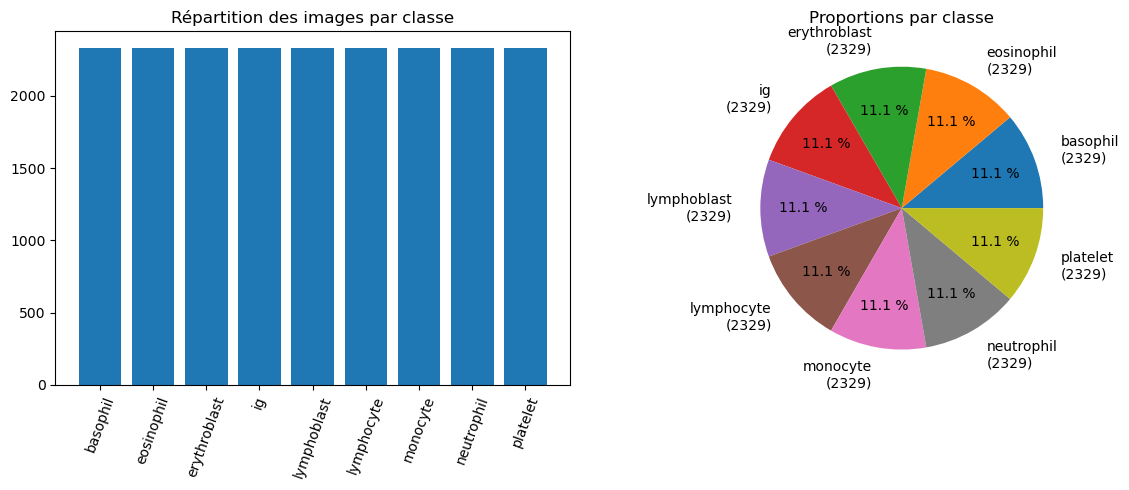

{'basophil': 2329,
 'eosinophil': 2329,
 'erythroblast': 2329,
 'ig': 2329,
 'lymphoblast': 2329,
 'lymphocyte': 2329,
 'monocyte': 2329,
 'neutrophil': 2329,
 'platelet': 2329}

In [21]:
data_viz(X = X_train_ros, y= y_train_ros)

### b. UnderSampling

In [22]:
# Sous-échantillonnage uniquement sur train : cette classe du module imbalanced-learn supprime aléatoirement des exemples de la classe majoritaire jusqu'à équilibrer les classes.
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_flat, y_train)

810 images found in 0s, belonging to 9 classes: ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphoblast', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


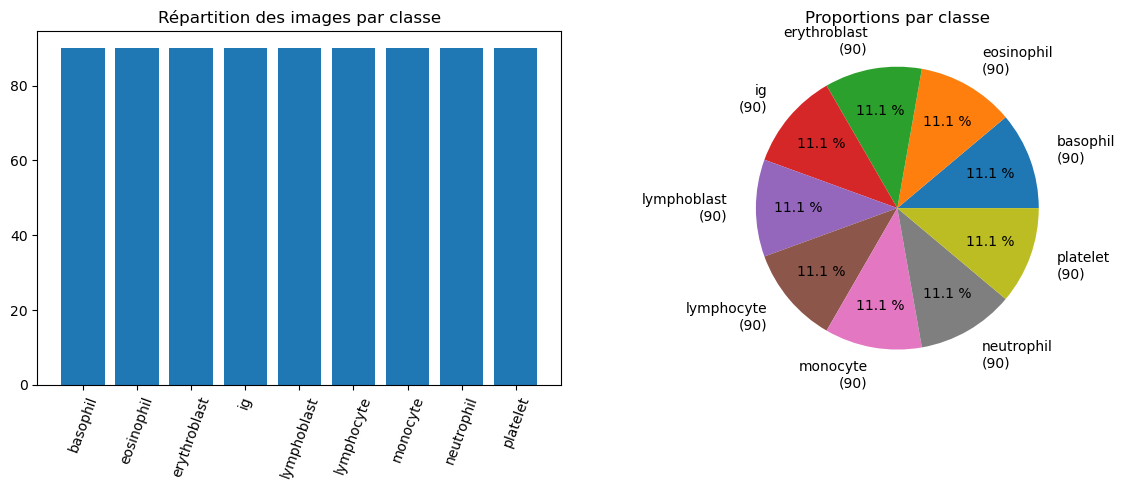

{'basophil': 90,
 'eosinophil': 90,
 'erythroblast': 90,
 'ig': 90,
 'lymphoblast': 90,
 'lymphocyte': 90,
 'monocyte': 90,
 'neutrophil': 90,
 'platelet': 90}

In [23]:
data_viz(X = X_train_rus, y = y_train_rus)

## 5. Binarization
Binarization = Segmentation by Thresholding

### a. Example
Binarization of 1 random image from X_train

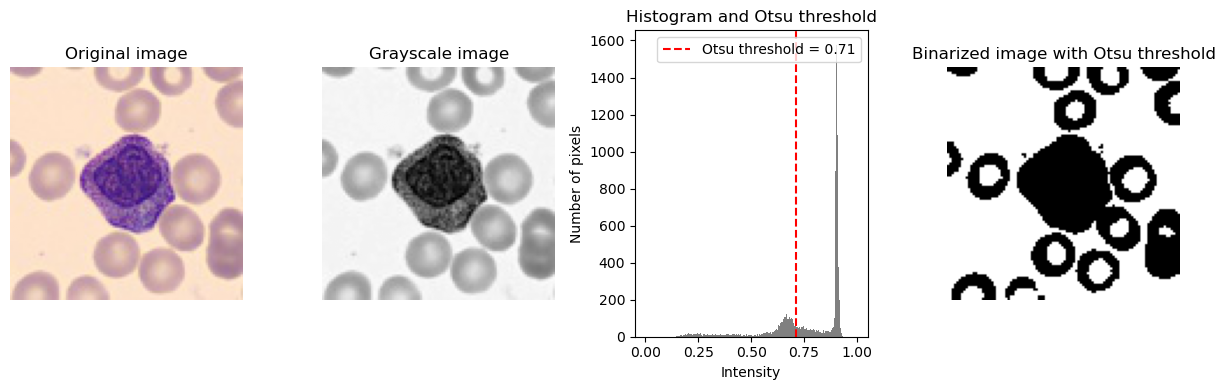

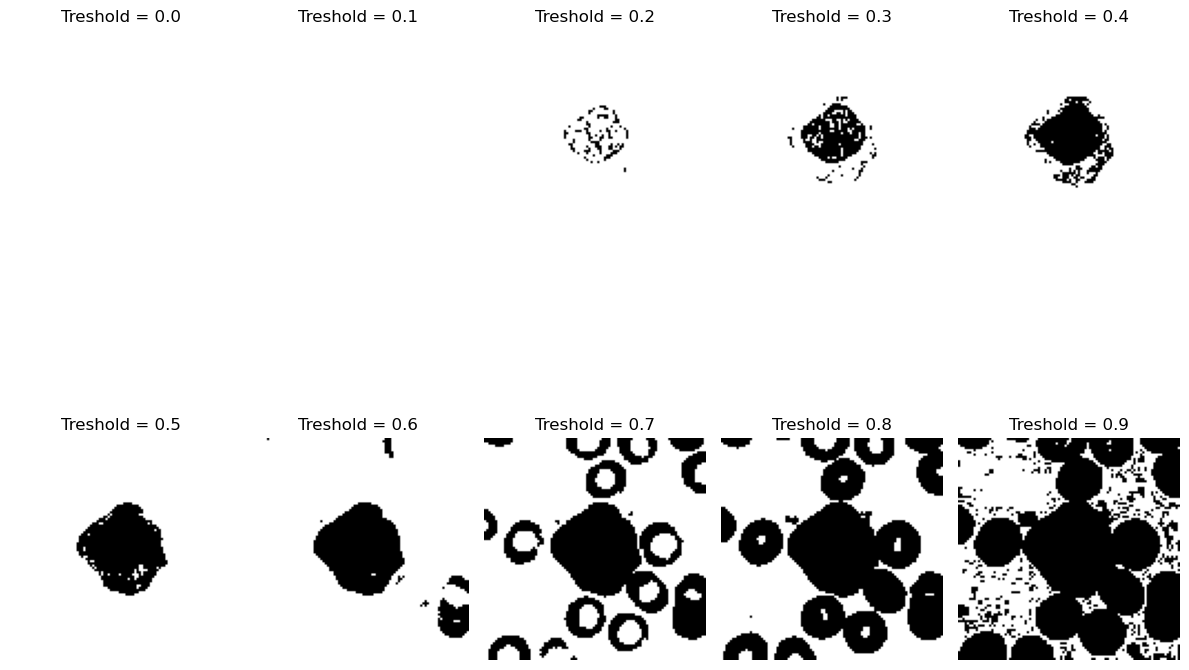

In [24]:
# Sélection d'une image aléatoire
n = np.random.randint(0, len(X_train))
img = X_train[n]

# Normalisation de l'image
img = img/255.0

# Affichage original
gray_img = rgb2gray(img)

plt.figure(figsize=(12,4))
plt.subplot(1, 4, 1)
plt.imshow(img)
plt.title("Original image")
plt.axis('off')

# Affichage en gray scale
plt.subplot(1, 4, 2)
plt.imshow(gray_img, cmap="gray")
plt.title("Grayscale image")
plt.axis('off')

# Affichage de l'istogramme des intensités
plt.subplot(1, 4, 3)
plt.hist(gray_img.ravel(),       #gray_img.ravel() : transforme l'image 2D en 1D pour histogramme.
         bins=256,               #bins=256 : divisions fines entre 0 et 1 (comme les niveaux de gris).
         range=(0, 1),           #range=(0, 1) : force l’échelle correcte pour les images normalisées.
         color='gray')           #color='gray' : visuel cohérent avec le contenu.

# Ajout du seuil Otsu sur l'histogramme
seuil_otsu = threshold_otsu(gray_img) # Calcul du seuil automatique Otsu
plt.axvline(seuil_otsu, color='red', linestyle='--', label=f'Otsu threshold = {seuil_otsu:.2f}')
plt.legend()
plt.title('Histogram and Otsu threshold')
plt.xlabel("Intensity")
plt.ylabel("Number of pixels")

# Affichage de l'image binarisée par Otsu
binary_otsu = gray_img > seuil_otsu # Binarisation avec ce seuil
plt.subplot(1, 4, 4)
plt.imshow(binary_otsu, cmap='gray', vmin=0, vmax=1)
plt.title('Binarized image with Otsu threshold')
plt.axis('off')

plt.tight_layout()
plt.show()

# Binarization with various tresholds
plt.figure(figsize=(12, 10))
for i in range(10):
    threshold = i * 0.1
    binarized = gray_img > threshold
    plt.subplot(2, 5, i + 1)
    plt.imshow(binarized, cmap="gray", vmin=0, vmax=1)  # vmin et vmax sont ajoutées pour que les images toutes blanches n'apparaissent pas toute noire
    plt.title(f"Treshold = {threshold:.1f}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### b. Binarization of the 3 datasets

using Otsu threshold

ℹ️ Otsu threshold = 0.7332573291973039


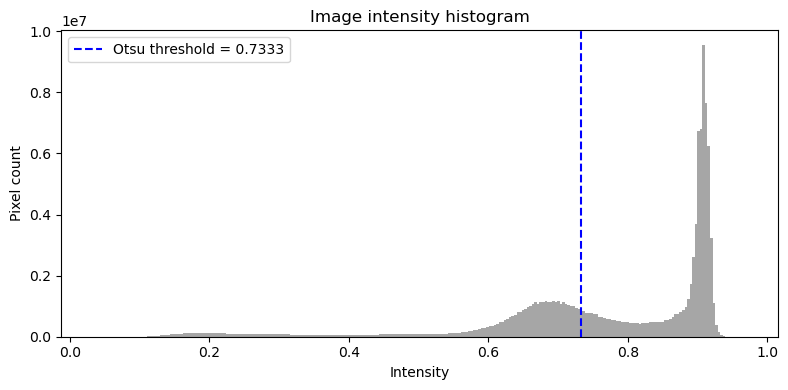

In [25]:
threshold = 'otsu'
ob = OtsuBinarizer(threshold = threshold)
X_train_otsu = ob.fit_transform(X_train)
X_valid_otsu = ob.transform(X_valid)
X_test_otsu = ob.transform(X_valid)
ob.show_histogram(X_train)
otsu = ob.get_otsu()

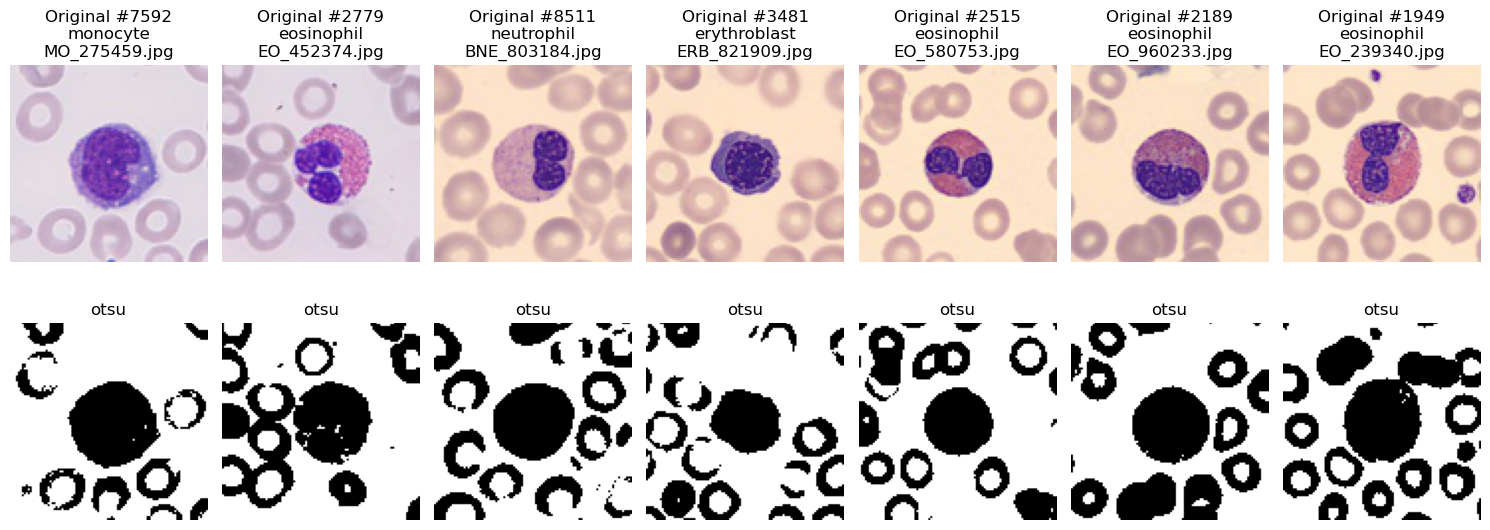

In [26]:
ob.show_samples(X_train, y_train, names_train)

using custom threshold

ℹ️ Otsu threshold = 0.7332573291973039


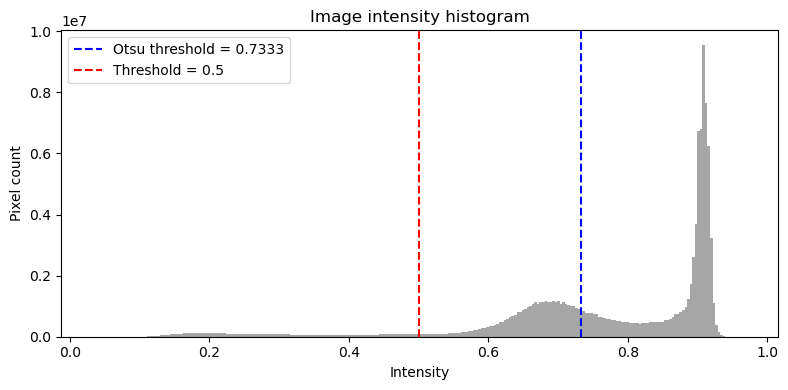

In [27]:
threshold = 0.5
ob = OtsuBinarizer(threshold = threshold)
X_train_bin = ob.fit_transform(X_train)
X_valid_bin = ob.transform(X_valid)
X_test_bin = ob.transform(X_valid)
ob.show_histogram(X_train)
otsu = ob.get_otsu()

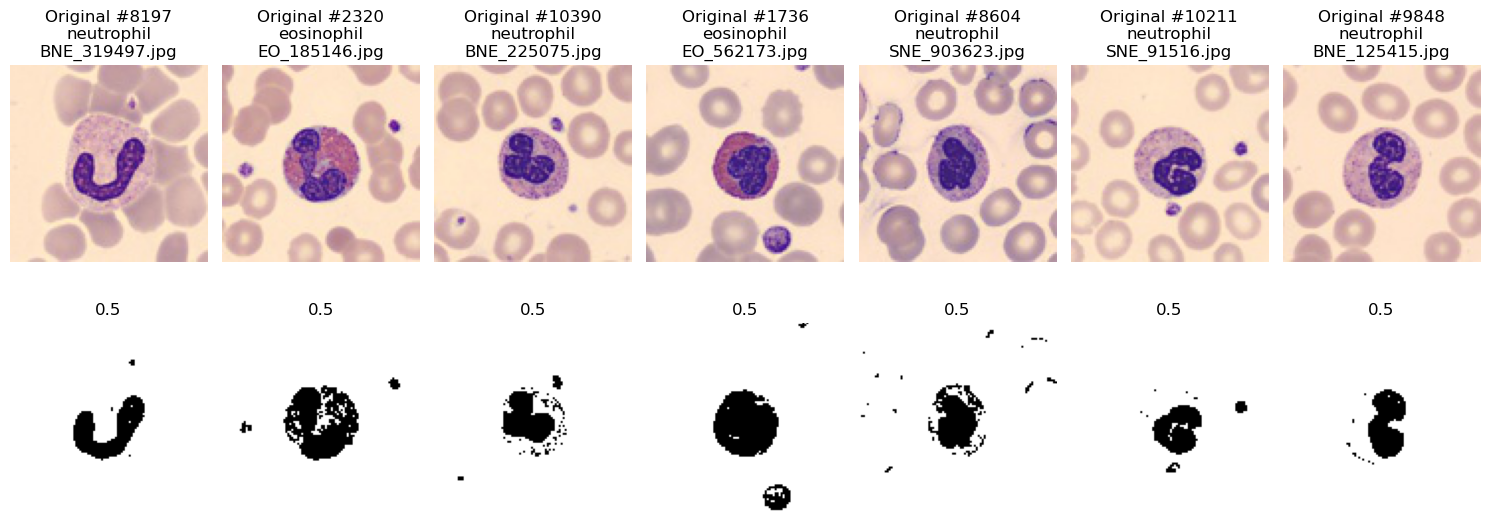

In [28]:
ob.show_samples(X_train, y_train, names_train)

12042 images found in 0s, belonging to 9 classes: ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphoblast', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


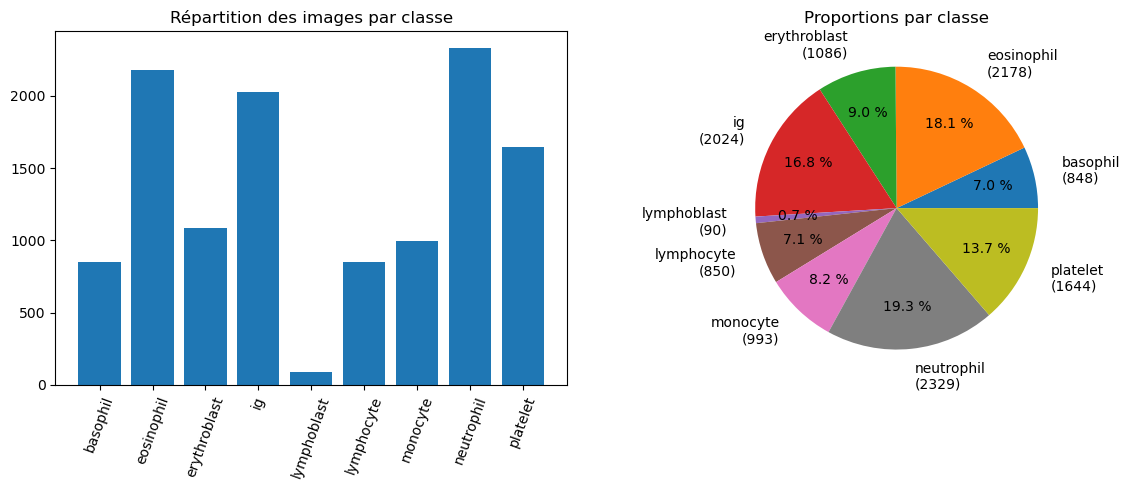

{'basophil': 848,
 'eosinophil': 2178,
 'erythroblast': 1086,
 'ig': 2024,
 'lymphoblast': 90,
 'lymphocyte': 850,
 'monocyte': 993,
 'neutrophil': 2329,
 'platelet': 1644}

In [29]:
data_viz(X = X_train_bin, y = y_train)

X_train_bin is saved to check out binarization

In [30]:
if SAVE_BIN:
    save_images(X_train_otsu, y_train, output_dir= path_DS_train_otsu, names=names_train, overwrite= False)
    save_images(X_valid_otsu, y_valid, output_dir= path_DS_valid_otsu, names=names_valid, overwrite= False)
    save_images(X_test_otsu, y_test, output_dir= path_DS_test_otsu, names=names_test, overwrite= False)
    save_images(X_train_bin, y_train, output_dir= path_DS_train_bin, names=names_train, overwrite= False)
    save_images(X_valid_bin, y_valid, output_dir= path_DS_valid_bin, names=names_valid, overwrite= False)
    save_images(X_test_bin, y_test, output_dir= path_DS_test_bin, names=names_test, overwrite= False)

# V. Machine Learning

## 1. Evaluate ML models and datasets

TODO : early_stopping_rounds pour XGB, CAT et LGBM à 5 ou 10 et remettre iterator par défaut !?

TODO : ajouter dataset réduction de dimension par PCA

TODO : ajouter show_thresholds dans OtsuBinarizer qui montre les binarizations selon différents taux range(0,1,0.1) ainsi que otsu en jouant sur self.treshold_ et self.transform !

### a. Define ML models

In [31]:
#verbosity
verbose = True

#Number of cores used
n_cores = os.cpu_count()
print("Total number of logical cores:", n_cores)
n_jobs = n_cores//2 # use -1 for all cores, defaut = n_cores//2, increase for higher performance, decrease if kernel dies
print("Number of logical cores used for parallel processing:", n_cores if n_jobs == -1 else n_jobs)

#Random state
random_state = 42 #int or None for no seed

# Random Forest
RF=ensemble.RandomForestClassifier(n_jobs=n_jobs, random_state=random_state)

# Support Vector Machine
SVM=SVC(random_state=random_state) # le paramètre n_jobs n'existe pas dans SVC car il utilise un seul cœur CPU

#k-Nearest Neighbors    
KNN=KNeighborsClassifier(n_jobs = n_jobs)   #le paramètre random_state n'existe pas dans KNN car c’est un algorithme non probabiliste et déterministe

# XGBoost
XGB=XGBClassifier(
            num_class=len(set(y_train)),   # nombre de classes
            objective='multi:softmax',     # pour la classification multi-classes
            n_estimators=20,               # default = 100
            n_jobs = n_jobs,
            random_state=random_state)

# CatBoost
CAT=CatBoostClassifier(
            iterations=20,                # default = 1000
            thread_count= n_jobs,
            random_seed=random_state)

# LightGBM
LGB=LGBMClassifier(
            n_estimators=20,              # default = 100
            objective = 'multiclass',
            n_jobs=n_jobs,
            random_state=random_state)

Total number of logical cores: 16
Number of logical cores used for parallel processing: 8


### b. Select models

In [32]:
models = [RF, SVM, KNN, XGB, CAT, LGB] #default = [RF, SVM, KNN, XGB, CAT, LGB]
models = [RF, KNN, XGB, CAT, LGB]

### c. Define datasets

In [33]:
RESIZED = (X_train, X_valid, y_train, y_valid, "Resized")
ROS = (X_train_ros, X_valid, y_train_ros, y_valid, "Over Sampled")
RUS = (X_train_rus, X_valid, y_train_rus, y_valid, "Under Sampled")
OTSU = (X_train_otsu, X_valid_otsu, y_train, y_valid, "Otsu")
BIN = (X_train_bin, X_valid_bin, y_train, y_valid, "Binarized")

### d. Select datasets

In [34]:
datasets = [RESIZED, ROS, RUS, OTSU, BIN] #default = [RESIZED, ROS, RUS, OTSU, BIN]
datasets = [OTSU, BIN]

### e. Evaluate performances

In [35]:
ML_global_perf = evaluate_ML_global(models, datasets, verbose)

=== Otsu ===

RandomForestClassifier(n_jobs=8, random_state=42)
accuracy: 0.5416505230530801
duration: 2.280 s



col_0,basophil,eosinophil,erythroblast,ig,lymphoblast,lymphocyte,monocyte,neutrophil,platelet
row_0,,,,,,,,,
basophil,9,35,13,66,0,11,3,45,0
eosinophil,3,285,5,89,0,5,10,70,0
erythroblast,1,20,112,7,0,35,2,26,29
ig,10,132,5,211,0,9,16,51,0
lymphoblast,0,0,0,0,20,0,0,0,0
lymphocyte,8,3,51,5,0,89,0,23,3
monocyte,0,55,0,85,1,0,39,33,0
neutrophil,1,95,15,65,0,9,6,304,4
platelet,0,0,14,1,0,4,0,4,329


              precision    recall  f1-score   support

    basophil       0.28      0.05      0.08       182
  eosinophil       0.46      0.61      0.52       467
erythroblast       0.52      0.48      0.50       232
          ig       0.40      0.49      0.44       434
 lymphoblast       0.95      1.00      0.98        20
  lymphocyte       0.55      0.49      0.52       182
    monocyte       0.51      0.18      0.27       213
  neutrophil       0.55      0.61      0.58       499
    platelet       0.90      0.93      0.92       352

    accuracy                           0.54      2581
   macro avg       0.57      0.54      0.53      2581
weighted avg       0.53      0.54      0.52      2581

KNeighborsClassifier(n_jobs=8)
accuracy: 0.3831848120883379
duration: 2.003 s



col_0,basophil,eosinophil,erythroblast,ig,lymphoblast,lymphocyte,monocyte,neutrophil,platelet
row_0,,,,,,,,,
basophil,9,82,60,27,1,0,2,1,0
eosinophil,12,323,58,57,4,0,5,8,0
erythroblast,6,20,160,10,2,2,2,2,28
ig,18,212,62,129,1,0,5,7,0
lymphoblast,0,0,0,0,20,0,0,0,0
lymphocyte,10,15,146,5,0,3,0,3,0
monocyte,9,105,4,77,3,0,14,1,0
neutrophil,26,251,108,89,6,0,8,9,2
platelet,2,1,25,1,0,1,0,0,322


              precision    recall  f1-score   support

    basophil       0.10      0.05      0.07       182
  eosinophil       0.32      0.69      0.44       467
erythroblast       0.26      0.69      0.37       232
          ig       0.33      0.30      0.31       434
 lymphoblast       0.54      1.00      0.70        20
  lymphocyte       0.50      0.02      0.03       182
    monocyte       0.39      0.07      0.11       213
  neutrophil       0.29      0.02      0.03       499
    platelet       0.91      0.91      0.91       352

    accuracy                           0.38      2581
   macro avg       0.40      0.42      0.33      2581
weighted avg       0.40      0.38      0.32      2581

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gam

col_0,basophil,eosinophil,erythroblast,ig,lymphoblast,lymphocyte,monocyte,neutrophil,platelet
row_0,,,,,,,,,
basophil,21,38,10,77,0,14,6,16,0
eosinophil,11,297,11,84,0,4,24,36,0
erythroblast,7,21,111,14,0,37,3,9,30
ig,10,144,5,213,0,9,33,20,0
lymphoblast,0,0,0,0,20,0,0,0,0
lymphocyte,13,4,49,11,0,98,0,5,2
monocyte,1,68,2,61,0,0,69,12,0
neutrophil,10,121,12,56,0,10,17,270,3
platelet,0,0,17,0,0,2,1,1,331


              precision    recall  f1-score   support

    basophil       0.29      0.12      0.16       182
  eosinophil       0.43      0.64      0.51       467
erythroblast       0.51      0.48      0.49       232
          ig       0.41      0.49      0.45       434
 lymphoblast       1.00      1.00      1.00        20
  lymphocyte       0.56      0.54      0.55       182
    monocyte       0.45      0.32      0.38       213
  neutrophil       0.73      0.54      0.62       499
    platelet       0.90      0.94      0.92       352

    accuracy                           0.55      2581
   macro avg       0.59      0.56      0.57      2581
weighted avg       0.56      0.55      0.55      2581

Learning rate set to 0.5
0:	learn: 1.6497710	total: 630ms	remaining: 12s
1:	learn: 1.5055928	total: 1.36s	remaining: 12.3s
2:	learn: 1.4164400	total: 2.1s	remaining: 11.9s
3:	learn: 1.3599857	total: 2.82s	remaining: 11.3s
4:	learn: 1.3199293	total: 3.55s	remaining: 10.6s
5:	learn: 1.2895772	tot

/home/did/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


col_0,basophil,eosinophil,erythroblast,ig,lymphoblast,lymphocyte,monocyte,neutrophil,platelet
row_0,,,,,,,,,
basophil,18,40,15,68,0,7,6,27,1
eosinophil,16,262,8,93,0,1,23,64,0
erythroblast,6,20,117,8,0,35,3,19,24
ig,15,160,8,166,0,10,34,41,0
lymphoblast,0,0,0,0,20,0,0,0,0
lymphocyte,11,1,53,7,0,83,0,23,4
monocyte,2,60,2,64,1,1,61,22,0
neutrophil,10,120,20,54,0,4,10,278,3
platelet,0,0,20,1,0,4,1,4,322


              precision    recall  f1-score   support

    basophil       0.23      0.10      0.14       182
  eosinophil       0.40      0.56      0.46       467
erythroblast       0.48      0.50      0.49       232
          ig       0.36      0.38      0.37       434
 lymphoblast       0.95      1.00      0.98        20
  lymphocyte       0.57      0.46      0.51       182
    monocyte       0.44      0.29      0.35       213
  neutrophil       0.58      0.56      0.57       499
    platelet       0.91      0.91      0.91       352

    accuracy                           0.51      2581
   macro avg       0.55      0.53      0.53      2581
weighted avg       0.51      0.51      0.51      2581

LGBMClassifier(n_estimators=20, n_jobs=8, objective='multiclass',
               random_state=42)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you ca

/home/did/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


col_0,basophil,eosinophil,erythroblast,ig,lymphoblast,lymphocyte,monocyte,neutrophil,platelet
row_0,,,,,,,,,
basophil,19,34,12,75,0,12,5,25,0
eosinophil,13,270,10,90,1,6,20,57,0
erythroblast,9,20,98,11,0,45,3,16,30
ig,17,126,12,224,0,7,30,18,0
lymphoblast,0,0,0,0,20,0,0,0,0
lymphocyte,13,1,46,10,0,99,0,10,3
monocyte,1,54,0,72,1,0,63,22,0
neutrophil,7,98,18,53,0,5,13,303,2
platelet,0,0,11,0,0,6,1,2,332


              precision    recall  f1-score   support

    basophil       0.24      0.10      0.15       182
  eosinophil       0.45      0.58      0.50       467
erythroblast       0.47      0.42      0.45       232
          ig       0.42      0.52      0.46       434
 lymphoblast       0.91      1.00      0.95        20
  lymphocyte       0.55      0.54      0.55       182
    monocyte       0.47      0.30      0.36       213
  neutrophil       0.67      0.61      0.64       499
    platelet       0.90      0.94      0.92       352

    accuracy                           0.55      2581
   macro avg       0.56      0.56      0.55      2581
weighted avg       0.55      0.55      0.54      2581



Otsu             
                        Accuracy Duration (s)
Model                                        
RandomForestClassifier  0.541651        2.980
KNeighborsClassifier    0.383185        2.643
XGBClassifier           0.554049        6.161
CatBoostClassifier      0.514142       41.154
LGBMClassifier          0.553274       10.961

=== Binarized ===

RandomForestClassifier(n_jobs=8, random_state=42)
accuracy: 0.7322743122820612
duration: 2.153 s



col_0,basophil,eosinophil,erythroblast,ig,lymphoblast,lymphocyte,monocyte,neutrophil,platelet
row_0,,,,,,,,,
basophil,83,23,0,44,0,17,14,1,0
eosinophil,11,366,1,44,0,2,9,34,0
erythroblast,8,0,137,23,0,26,1,18,19
ig,20,34,1,320,0,15,11,33,0
lymphoblast,0,1,1,9,9,0,0,0,0
lymphocyte,9,0,10,26,0,134,0,3,0
monocyte,13,47,0,108,0,1,42,2,0
neutrophil,0,9,7,5,0,2,0,476,0
platelet,0,0,28,0,0,1,0,0,323


              precision    recall  f1-score   support

    basophil       0.58      0.46      0.51       182
  eosinophil       0.76      0.78      0.77       467
erythroblast       0.74      0.59      0.66       232
          ig       0.55      0.74      0.63       434
 lymphoblast       1.00      0.45      0.62        20
  lymphocyte       0.68      0.74      0.71       182
    monocyte       0.55      0.20      0.29       213
  neutrophil       0.84      0.95      0.89       499
    platelet       0.94      0.92      0.93       352

    accuracy                           0.73      2581
   macro avg       0.74      0.65      0.67      2581
weighted avg       0.73      0.73      0.72      2581

KNeighborsClassifier(n_jobs=8)
accuracy: 0.5218907400232468
duration: 2.003 s



col_0,basophil,eosinophil,erythroblast,ig,lymphoblast,lymphocyte,monocyte,neutrophil,platelet
row_0,,,,,,,,,
basophil,94,21,3,27,0,17,19,1,0
eosinophil,125,136,6,115,0,11,34,40,0
erythroblast,16,4,122,17,0,43,3,6,21
ig,78,64,18,186,0,50,17,20,1
lymphoblast,1,4,0,10,5,0,0,0,0
lymphocyte,15,2,7,13,0,138,0,6,1
monocyte,79,43,6,61,0,4,17,3,0
neutrophil,6,11,40,40,0,47,1,354,0
platelet,0,1,46,1,0,4,0,5,295


              precision    recall  f1-score   support

    basophil       0.23      0.52      0.32       182
  eosinophil       0.48      0.29      0.36       467
erythroblast       0.49      0.53      0.51       232
          ig       0.40      0.43      0.41       434
 lymphoblast       1.00      0.25      0.40        20
  lymphocyte       0.44      0.76      0.56       182
    monocyte       0.19      0.08      0.11       213
  neutrophil       0.81      0.71      0.76       499
    platelet       0.93      0.84      0.88       352

    accuracy                           0.52      2581
   macro avg       0.55      0.49      0.48      2581
weighted avg       0.55      0.52      0.52      2581

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gam

col_0,basophil,eosinophil,erythroblast,ig,lymphoblast,lymphocyte,monocyte,neutrophil,platelet
row_0,,,,,,,,,
basophil,69,18,1,59,0,17,17,1,0
eosinophil,13,346,1,61,0,4,17,25,0
erythroblast,8,2,131,24,0,25,4,15,23
ig,21,22,2,324,0,17,28,20,0
lymphoblast,0,1,0,8,10,1,0,0,0
lymphocyte,9,0,8,24,0,139,0,2,0
monocyte,17,31,1,101,0,1,58,4,0
neutrophil,0,17,20,19,0,5,1,437,0
platelet,0,0,23,0,0,2,0,3,324


              precision    recall  f1-score   support

    basophil       0.50      0.38      0.43       182
  eosinophil       0.79      0.74      0.77       467
erythroblast       0.70      0.56      0.63       232
          ig       0.52      0.75      0.61       434
 lymphoblast       1.00      0.50      0.67        20
  lymphocyte       0.66      0.76      0.71       182
    monocyte       0.46      0.27      0.34       213
  neutrophil       0.86      0.88      0.87       499
    platelet       0.93      0.92      0.93       352

    accuracy                           0.71      2581
   macro avg       0.72      0.64      0.66      2581
weighted avg       0.72      0.71      0.71      2581

Learning rate set to 0.5
0:	learn: 1.5025415	total: 698ms	remaining: 13.3s
1:	learn: 1.3176444	total: 1.49s	remaining: 13.4s
2:	learn: 1.1943442	total: 2.32s	remaining: 13.1s
3:	learn: 1.1323050	total: 3.11s	remaining: 12.4s
4:	learn: 1.0695155	total: 3.91s	remaining: 11.7s
5:	learn: 1.0338563	

/home/did/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


col_0,basophil,eosinophil,erythroblast,ig,lymphoblast,lymphocyte,monocyte,neutrophil,platelet
row_0,,,,,,,,,
basophil,72,16,0,52,0,19,22,1,0
eosinophil,26,310,3,63,0,5,20,40,0
erythroblast,11,1,114,18,1,31,1,25,30
ig,31,40,4,276,0,30,22,31,0
lymphoblast,0,1,1,10,8,0,0,0,0
lymphocyte,8,0,10,27,0,132,0,5,0
monocyte,24,47,1,96,0,1,42,2,0
neutrophil,0,26,22,8,0,7,0,435,1
platelet,0,0,26,0,0,2,0,0,324


              precision    recall  f1-score   support

    basophil       0.42      0.40      0.41       182
  eosinophil       0.70      0.66      0.68       467
erythroblast       0.63      0.49      0.55       232
          ig       0.50      0.64      0.56       434
 lymphoblast       0.89      0.40      0.55        20
  lymphocyte       0.58      0.73      0.65       182
    monocyte       0.39      0.20      0.26       213
  neutrophil       0.81      0.87      0.84       499
    platelet       0.91      0.92      0.92       352

    accuracy                           0.66      2581
   macro avg       0.65      0.59      0.60      2581
weighted avg       0.66      0.66      0.65      2581

LGBMClassifier(n_estimators=20, n_jobs=8, objective='multiclass',
               random_state=42)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you ca

/home/did/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


col_0,basophil,eosinophil,erythroblast,ig,lymphoblast,lymphocyte,monocyte,neutrophil,platelet
row_0,,,,,,,,,
basophil,72,20,0,62,0,13,13,2,0
eosinophil,13,349,0,49,0,2,14,40,0
erythroblast,8,2,132,26,0,19,3,21,21
ig,21,24,3,327,4,15,17,23,0
lymphoblast,0,1,1,7,11,0,0,0,0
lymphocyte,10,0,10,22,0,137,0,3,0
monocyte,16,45,1,94,0,1,53,3,0
neutrophil,0,19,14,18,0,2,1,445,0
platelet,0,0,22,0,0,1,0,3,326


              precision    recall  f1-score   support

    basophil       0.51      0.40      0.45       182
  eosinophil       0.76      0.75      0.75       467
erythroblast       0.72      0.57      0.64       232
          ig       0.54      0.75      0.63       434
 lymphoblast       0.73      0.55      0.63        20
  lymphocyte       0.72      0.75      0.74       182
    monocyte       0.52      0.25      0.34       213
  neutrophil       0.82      0.89      0.86       499
    platelet       0.94      0.93      0.93       352

    accuracy                           0.72      2581
   macro avg       0.70      0.65      0.66      2581
weighted avg       0.72      0.72      0.71      2581



Binarized             
                        Accuracy Duration (s)
Model                                        
RandomForestClassifier  0.732274        2.817
KNeighborsClassifier    0.521891        2.640
XGBClassifier           0.712127        5.749
CatBoostClassifier      0.663696       42.887
LGBMClassifier          0.717551        5.167

=== GLOBAL ===

5 models evaluated on 2 datasets in 123 s



Otsu              Binarized              📊 Average  \
                       Accuracy Duration (s)  Accuracy Duration (s)  Accuracy   
Model                                                                           
RandomForestClassifier    0.542            3     0.732            3     0.637   
KNeighborsClassifier      0.383            3     0.522            3     0.453   
XGBClassifier             0.554            6     0.712            6     0.633   
CatBoostClassifier        0.514           41     0.664           43     0.589   
LGBMClassifier            0.553           11     0.718            5     0.635   
📊 Average                 0.509           13     0.670           12     0.589   

                                     
                       Duration (s)  
Model                                
RandomForestClassifier            3  
KNeighborsClassifier              3  
XGBClassifier                     6  
CatBoostClassifier               42  
LGBMClassifier                    8  
📊 Average                        12

In [36]:
all_bin_acc = get_all_ML_acc(X_train_bin, X_valid_bin, y_train, y_valid, RF, SVM, KNN, XGB, CAT, LGB, verbose, n_jobs, random_state)
all_bin_acc.columns = pd.MultiIndex.from_product([['Binarized'], all_bin_acc.columns]) #ajoute un label chapô sur les colonnes

NameError: name 'get_ML_acc' is not defined

## 2. Fine tuning
Random Forest classifier with Resized dataset
XGBoost classifier et LGBM with Binarized dataset

### a. Random Forest

### b. XGBoost

## 3. Cross Validation of the "best" model with "best" parameters
using Stratified k-Fold (on X_train only)

In [ ]:
# Version sklearn

# Définition du modèle selon fine tuning

model = ensemble.RandomForestClassifier(n_jobs=-1)

# Définition du Stratified K-Fold Cross Validation
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state = 42)

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)

# Calcul des scores via cross validation
scores = cross_val_score(model, X_train_flat, y_train_encoded, cv=skf, verbose = 1) #verbose = 1 pour message basique par fold, >1 plus de détail...

# Affichage des accuracies pour chaque fold, leur moyenne et écart-type
print(model)
print(f"Accuracy des {k} folds: {scores}")
print(f"Moyenne: {scores.mean():.4f} | Écart-type: {scores.std():.4f}")

Validation k-Fold version xgb

In [ ]:
# Encodage des labels
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)

# Création d'un DMatrix
dtrain = xgb.DMatrix(X_train_flat, label=y_train_encoded)

# Définition des paramètres du modèle
params = {
    'objective': 'multi:softmax',
    'num_class': len(set(y_train)),
    'n_jobs' : -1}


# Appel de la cross-validation
results = xgb.cv(
    params,
    dtrain,
    num_boost_round=50,
    nfold=5,
    stratified=True,
    early_stopping_rounds=5,
    seed=42,
    verbose_eval=True,
    as_pandas=True
)


In [ ]:
display(results)

## 4. Final evaluation
evaluation on X_test (for the first time)

In [ ]:
X_train_valid_flat = np.vstack([X_train_flat, X_valid_flat]) # Concaténation verticale des données train et valid
y_train_valid = np.concatenate([y_train, y_valid])           # Concaténation horziontale des labels (car flat)

# Définition du modèle selon fine tuning
model = XGBClassifier(
            num_class=len(set(y_train_valid)),               # nombre de classes
            objective='multi:softmax',                     
            n_jobs = -1,
            n_estimators=20,
            random_state=42)

print(model)
encoder = LabelEncoder()
y_train_valid_encoded = encoder.fit_transform(y_train_valid)         # Encodage des labels

start_time = time.perf_counter()

model.fit(X_train_valid_flat, y_train_valid_encoded, verbose = 1)         # Entraînement du modèle sur train+valid

y_pred_encoded = model.predict(X_test_flat)                  # Prédiction sur test

y_pred = encoder.inverse_transform(y_pred_encoded)           # Décodage des prédictions

accuracy = accuracy_score(y_test, y_pred)                    # Calcul de l'accuracy

end_time = time.perf_counter()         
predict_time = end_time - start_time   

print(f'duration: {predict_time:.3f} s')                   # Affichage du temps de calcul
print('accuracy:', accuracy)                                 # Affichage de l'accuracy
display(pd.crosstab(y_test, y_pred))                         #              la matrice de confusion
print(classification_report(y_test, y_pred))                 #              le rapport de classification

# VI. Deep Learning

##1. VGG16

Génération d'images à partir d'un répertoire d'images d'enTRAINement et de TEST

In [ ]:
def DidDataGen(directory_train, directory_test, target_size = (100,100), batch_size = 32, shear_range = 0.2, zoom_range = 0.2,
                rotation_range = 359, horizontal_flip = True, vertical_flip = True):

  from tensorflow.keras.preprocessing.image import ImageDataGenerator
  from tensorflow.keras.applications.vgg16 import preprocess_input
  import os

  train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                    shear_range = shear_range, # plage d'étirement
                                    zoom_range = zoom_range,  # plage d'agrandissement
                                    rotation_range = rotation_range, # plage de rotation en degré
                                    horizontal_flip = horizontal_flip,  #retournement horizontal aléatoire
                                    vertical_flip = vertical_flip,  #retournement vertical aléatoire
                                    )

  test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

  train_generator = train_datagen.flow_from_directory(directory = directory_train,
                                                            class_mode ="sparse",
                                                            target_size=target_size,
                                                            batch_size=batch_size)

  test_generator = test_datagen.flow_from_directory(directory = directory_test,
                                                          class_mode ="sparse",
                                                          target_size=target_size,
                                                          batch_size=batch_size)

    # compte le nb de sous-dossiers dans directory_train
  n_class=0
  for file in os.listdir(directory_train):
      d = os.path.join(directory_train, file)
      if os.path.isdir(d):
          n_class += 1

  return train_generator, test_generator, n_class

In [ ]:
train_generator, test_generator, n_class = DidDataGen(path_DS_train, path_DS_test, target_size = (100,100), batch_size = 32, shear_range = 0.2, zoom_range = 0.2,
                rotation_range = 359, horizontal_flip = True, vertical_flip = True)

Création et entrainement de plusieurs modèles VGG16 (à 21 couches) selon différents paramètres :
 * nb de couches defreezées = 4, 12, 21
 * taille du batch = 32 ou 64
 * learning rate évolutif par plateau de val_loss (callback)

In [ ]:
def DidVGG16(train_generator, test_generator, n_class, n_layers_trainable = 4, learning_rate = 1e-4, nb_epochs = 30, batch_size = 32, model_eval = False):

  from tensorflow.keras.applications.vgg16 import VGG16
  from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
  from tensorflow.keras.optimizers import Adam
  from tensorflow.keras.models import Model, Sequential
  from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
  import matplotlib.pyplot as plt

  # Modèle VGG16
  base_model = VGG16(weights='imagenet', include_top=False)

  # Freeze toutes les couches du VGG16 sauf les n dernières (si n différent de 0)
  for layer in base_model.layers:
    layer.trainable = False

  if n_layers_trainable != 0:
    for layer in base_model.layers[- n_layers_trainable:]:
      layer.trainable = True

  # Callbacks
  early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0.01, mode ='min', patience = 6, verbose = 1)
  reduce_learning_rate = ReduceLROnPlateau (monitor = 'val_loss', factor = 0.1, patience = 3, min_delta = 0.01, cooldown = 4, verbose = 1)
  callbacks = [reduce_learning_rate, early_stopping]

  # Construction du modèle
  model = Sequential()
  model.add(base_model)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(1024,activation='relu'))
  model.add(Dropout(rate=0.2))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(rate=0.2))
  model.add(Dense(n_class, activation='softmax'))

  model.compile(optimizer=Adam(learning_rate= learning_rate), loss='sparse_categorical_crossentropy', metrics=['acc'])

  # Entrainement du modèle

  print("Entrainement du modèle")
  history = model.fit(train_generator,
                      epochs = nb_epochs,
                      steps_per_epoch = train_generator.samples//batch_size,
                      validation_data = test_generator,
                      validation_steps = test_generator.samples//batch_size,
                      callbacks = callbacks)


  # Courbe de la fonction de coût et de précision en fonction de l'epoch

  print("\nCourbes de perte et de précision pour VGG16 avec les paramètres:\n # couches entrainées:", n_layers_trainable, "\n # learning rate init:", learning_rate,"\n # epochs            :",nb_epochs,"\n # batch size        :", batch_size)

  train_loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  train_acc = history.history["acc"]
  val_acc = history.history["val_acc"]

  plt.figure(figsize = (20, 7))

  plt.subplot(121)
  plt.plot(train_loss)
  plt.plot(val_loss)
  plt.title('Model loss per epoch')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='right')
  plt.grid(True)

  plt.subplot(122)
  plt.plot(train_acc)
  plt.plot(val_acc)
  plt.title('Model accuracy per epoch')
  plt.ylabel('acc')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='right')
  plt.grid(True)
    
  plt.show();

  print("\n", model.summary())

    # Evaluation du modèle (un peu long donc désactivée par défaut)
  if model_eval == True:
    print("\nEvaluation du modèle sur l'ensemble de test augmenté par génération de données:")
    score = model.evaluate(test_generator)
    return model, history, score
  else:
    return model, history

In [ ]:
model_4_64,_,_ = DidVGG16(train_generator, test_generator, n_class, n_layers_trainable = 4, learning_rate = 1e-4, nb_epochs = 30, batch_size = 64, model_eval = True)
DidSave(model_4_64, '/content/drive/MyDrive/BD/model_4_layers_64_batch')

In [ ]:
model_0_64,_,_ = DidVGG16(train_generator, test_generator, n_class, n_layers_trainable = 0, learning_rate = 1e-4, nb_epochs = 30, batch_size = 64, model_eval = True)
DidSave(model_0_64, '/content/drive/MyDrive/BD/model_0_layers_64_batch')

In [ ]:
model_12_64,_,_ = DidVGG16(train_generator, test_generator, n_class, n_layers_trainable = 12, learning_rate = 1e-4, nb_epochs = 30, batch_size = 64, model_eval = True)

In [ ]:
model_21_32,_,_ = DidVGG16(train_generator, test_generator, n_class, n_layers_trainable = 21, learning_rate = 1e-4, nb_epochs = 30, batch_size = 32, model_eval = True)

In [ ]:
model_21_64,_,_ = DidVGG16(train_generator, test_generator, n_class, n_layers_trainable = 21, learning_rate = 1e-4, nb_epochs = 30, batch_size = 64, model_eval = True)

Sauvegarde des modèles (en cas de plantage de l'environnement pour saturation de RAM)

In [ ]:
def DidSave(variable, fichier):
  import pickle
  f = open(fichier,"wb")
  pickle.dump(variable,f)
  f.close()

def DidLoad(fichier):
  import pickle
  f = open(fichier,"rb")
  variable = pickle.load(f)
  f.close()
  return variable

In [ ]:
#DidSave(model_12_64, '/content/drive/MyDrive/BD/model_12_layers_64_batch')

In [ ]:
#DidSave(model_21_64, '/content/drive/MyDrive/BD/model_16_layers_64_batch')

Feature Extraction en sortie des couches 2 et 5 puis entrainement de différents modèles de classification (Arbre de décision, SVM, Random Forest et XGBoost)

In [ ]:
def DidFeatureExtractionClassification(X, Y, model, test_size = 0.2, layers_output = 2 , xgb = False):

  # extraction des features de la couche 2 et entrainement d'un modèle de classification
  from sklearn.model_selection import train_test_split
  from tensorflow.keras.models import Model
  from tensorflow.keras.applications.vgg16 import preprocess_input

  X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=test_size)

  intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[layers_output].output)
  print('Train feature extraction')
  X_train_features = intermediate_layer_model.predict(preprocess_input(X_train))
  print('Test feature extraction')
  X_test_features = intermediate_layer_model.predict(preprocess_input(X_test))

  # decision tree
  from sklearn.tree import DecisionTreeClassifier
  clf = DecisionTreeClassifier()
  clf.fit(X_train_features, Y_train)
  print('score de classification avec Arbre de décision :', clf.score(X_test_features, Y_test))

  # SVM
  from sklearn.svm import SVC
  clf = SVC()
  clf.fit(X_train_features, Y_train)
  print('score de classification avec SVM               :', clf.score(X_test_features, Y_test))

  # Random Forest
  from sklearn import ensemble
  clf = ensemble.RandomForestClassifier(n_jobs=-1)
  clf.fit(X_train_features, Y_train)
  print('score de classification avec Random Forest     :', clf.score(X_test_features, Y_test))

  # XGBoost (un peu long donc désactivée par défaut)
  if xgb == True:

    import xgboost as xgb
    clf = xgb.XGBClassifier()

    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    le.fit(Y_train)
    Y_train_enc = le.transform(Y_train)
    Y_test_enc = le.transform(Y_test)

    clf.fit(X_train_features, Y_train_enc)
    print('score de classification avec XGBoost           :', clf.score(X_test_features, Y_test_enc))

  return X_train_features, X_test_features

In [ ]:
#X,Y = DidPreprocessing(path_DS, img_width = 100, img_height = 100, drop_duplicates = True)
#DidSave(X,'/content/drive/MyDrive/BD/variable_X')
#DidSave(Y,'/content/drive/MyDrive/BD/variable_Y')

In [ ]:
X = DidLoad('/content/drive/MyDrive/BD/variable_X')
Y = DidLoad('/content/drive/MyDrive/BD/variable_Y')

In [ ]:
for i in [2,5]:
  _,_ = DidFeatureExtractionClassification(X, Y, model_21_32, layers_output = i , xgb = True)

In [ ]:
for i in [2,5]:
  _,_ = DidFeatureExtractionClassification(X, Y, model_12_64, layers_output = i , xgb = True)

In [ ]:
for i in [2,5]:
  _,_ = DidFeatureExtractionClassification(X, Y, model_21_64, layers_output = i , xgb = True)

In [ ]:
model_12_32,_,_ = DidVGG16(train_generator, test_generator, n_class, n_layers_trainable = 12, learning_rate = 1e-4, nb_epochs = 30, batch_size = 32, model_eval = True)
DidSave(model_12_32, '/content/drive/MyDrive/BD/model_12_layers_32_batch')
for i in [2,5]:
  _,_ = DidFeatureExtractionClassification(X, Y, model_12_32, layers_output = i , xgb = True)


Scores de référence des 4 modèles sur les données sans feature extraction

In [ ]:
# en utilisant les ensembles d'entrainement et de test standardisés et réduits à 2 dimensions

# decision tree
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(X_train, Y_train)
print('score de classification avec Arbre de décision :', clf.score(X_test, Y_test))

# SVM
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train, Y_train)
print('score de classification avec SVM               :', clf.score(X_test, Y_test))

# Random Forest
from sklearn import ensemble
clf = ensemble.RandomForestClassifier(n_jobs=-1)
clf.fit(X_train, Y_train)
print('score de classification avec Random Forest     :', clf.score(X_test, Y_test))

# XGBoost
import xgboost as xgb
clf = xgb.XGBClassifier()

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Y_train)
Y_train_enc = le.transform(Y_train)
Y_test_enc = le.transform(Y_test)

clf.fit(X_train, Y_train_enc)
print('score de classification avec XGBoost           :', clf.score(X_test, Y_test_enc))

##2. ResNet50

In [ ]:
#création des datasets d'entrainement et de test à partir des fichiers jpg

import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import time

#import cv2
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as K

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import callbacks

from tensorflow.keras.applications.vgg16 import preprocess_input

train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   shear_range = 0.2, # plage d'étirement
                                   zoom_range = 0.2,  # plage d'agrandissement
                                   rotation_range = 359, # plage de rotation en degré
                                   horizontal_flip = True,  #retournement horizontal aléatoire
                                   vertical_flip = True,  #retournement vertical aléatoire
                                   )

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

train_generator = train_datagen.flow_from_directory(directory=path_DS_train,
                                                           class_mode ="sparse",
                                                           target_size=(100,100),
                                                           batch_size=32)

test_generator = test_datagen.flow_from_directory(directory=path_DS_test,
                                                  class_mode ="sparse",
                                                  target_size=(100,100),
                                                  batch_size=32)


In [ ]:
print("modele2 : C2 143 - 224x224 - lr 1e-4")

inputs = K.Input(shape=(224, 224, 3))

n_class = 9

resnet2 = K.applications.ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

for layer in resnet2.layers[:143]:
    layer.trainable = False

model2 = K.models.Sequential()
model2.add(K.layers.Lambda(lambda x: tf.image.resize(x, (224, 224))))
model2.add(resnet2)

model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dense(10, activation='softmax'))

ces = callbacks.EarlyStopping(monitor='accuracy', patience=4, mode='max', restore_best_weights=True)
crop = callbacks.ReduceLROnPlateau(monitor='accuracy', patience=2, verbose=2, mode='max')

model2.compile(loss='sparse_categorical_crossentropy',
              optimizer=K.optimizers.legacy.RMSprop(1e-4),
              metrics=['accuracy'])

history2 = model2.fit(train_generator,
                    batch_size=32,
                    epochs=100,
                    verbose=1,
                    validation_data=test_generator,
                    shuffle=True,
                    callbacks=[ces, crop])

In [ ]:
train_loss = history2.history["loss"]
val_loss = history2.history["val_loss"]
train_acc = history2.history["accuracy"]
val_acc = history2.history["val_accuracy"]

plt.figure(figsize = (20, 8))

plt.subplot(121)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model loss per epoch - Modele2')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')


plt.subplot(122)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model accuracy per epoch - Modele2')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.show();

In [ ]:
model2.summary()

In [ ]:
#permet de charger un modèle et de sortir son évaluation
model2 = tf.keras.models.load_model('/content/drive/MyDrive/BD/vf_model2')
model2.evaluate(test_generator)

In [ ]:
#on donne le chemin d'une image enregistrée sur pc
#et il ressort la classe prédite avec la probabilité
def test_from_local(chemin, model, test_generator):
    from tensorflow.keras.preprocessing import image
    import matplotlib.image as mpimg
    import numpy as np
    #met les images à la bonne dimension
    img = image.load_img(chemin, target_size=(100, 100))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    #obtenir l'indice de la classe la plus probable
    arg = int(tf.argmax(model.predict(x), axis=1).numpy())
    #obtenir la liste des noms des classes
    class_names = list(test_generator.class_indices.keys())
    #valeur de la probabilité que l'image appartienne à la classe
    proba = model.predict(x)[0][arg]

    return print("Cette image a", proba*100, "% de chance d'être un", class_names[arg])


In [ ]:
#quelques tests de la fonction précdente (qui fonctionne bien)
test_from_local("/content/drive/MyDrive/BD/a_tester_eosinophil.jpg", model2, test_generator)

In [ ]:
#on donne le chemin d'une image enregistrée sur pc
#et il ressort la classe prédite avec la probabilité
def test_from_url(image_url, model, test_generator):
    from tensorflow.keras.preprocessing import image
    import matplotlib.image as mpimg
    import numpy as np
    import urllib.request
    import io

    with urllib.request.urlopen(image_url) as url:
        image_data = url.read()

    img = image.load_img(io.BytesIO(image_data), target_size=(100, 100))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    arg = int(tf.argmax(model.predict(x), axis=1).numpy())

    class_names = list(test_generator.class_indices.keys())
    proba = model.predict(x)[0][arg]

    return print("Cette image a", proba*100, "% de chance d'être un", class_names[arg])


In [ ]:
#quelques tests de la fonction précdente (qui fonctionne bien)
test_from_url('http://bioimage.free.fr/hem_image/hem_img/pb32l.jpg', model2, test_generator)

##3. DenseNet121

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input , Dense
from tensorflow.keras.models import Model

import tensorflow as tf

In [ ]:
#Rechargement des données sauvegardées

X_dnet121 = X_reload
Y_dnet121 = Y_reload

In [ ]:
Y_dnet121

In [ ]:
#Fonction permettant de préparer les données pour petre conforme à l'entrée du DenseNet121

from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

encoder = LabelEncoder()
encoder.fit(Y_dnet121)
saved_labels = encoder.inverse_transform([i for i in range(9)])

def preprocess_data(X, Y):

    X = np.float32(X)
    Y = np.array(Y)
    """
    function that pre-processes th dataset as per
    densenet model requirements for input images
    labels are one-hot encoded
    """
    encoder = LabelEncoder()
    X = tf.keras.applications.densenet.preprocess_input(X)
    Y = encoder.fit_transform(Y)
    Y = tf.keras.utils.to_categorical(Y , 9)
    return X, Y


In [ ]:
from sklearn.model_selection import train_test_split

X_dnet121_train_base , X_dnet121_test_base , Y_dnet121_train_base , Y_dnet121_test_base = train_test_split( X_dnet121 , Y_dnet121 , test_size = 0.2 )


In [ ]:
#Preprocessing train data pour le densenet121

X_dnet121_train , Y_dnet121_train = preprocess_data( X_dnet121_train_base , Y_dnet121_train_base )

In [ ]:
#Preprocessing test data pour le densenet121

X_dnet121_test , Y_dnet121_test = preprocess_data( X_dnet121_test_base , Y_dnet121_test_base )

In [ ]:
#Implémentation du DenseNet121 et gel des 150 premières couches

base_densenet121 = tf.keras.applications.DenseNet121( include_top = False , weights = 'imagenet' )

In [ ]:
#Gel des 150 premières couches

for layer in base_densenet121.layers[ :149 ] :
  layer.trainable = False
for layer in base_densenet121.layers[ 149: ] :
  layer.trainable = True



In [ ]:
#Consutrction du modèle

model_densenet121 = tf.keras.models.Sequential()

In [ ]:
#Mise en forme des données pour le DenseNet121

model_densenet121.add( tf.keras.layers.Lambda( lambda x : tf.keras.backend.resize_images( x ,
                                                              height_factor = 1 ,
                                                              width_factor = 1 ,
                                                              data_format = 'channels_last' )  ) )

In [ ]:

#Construction du modèle (classifieur)

kernel_init = 'normal'

model_densenet121.add( base_densenet121 )
model_densenet121.add( tf.keras.layers.Flatten() )
model_densenet121.add( tf.keras.layers.BatchNormalization() )
model_densenet121.add( tf.keras.layers.Dense(512, activation='relu',kernel_initializer=kernel_init) )
model_densenet121.add( tf.keras.layers.Dropout(0.7) )
model_densenet121.add( tf.keras.layers.BatchNormalization() )
model_densenet121.add( tf.keras.layers.Dense(128, activation='relu',kernel_initializer=kernel_init))
model_densenet121.add( tf.keras.layers.Dropout(0.5) )
model_densenet121.add( tf.keras.layers.BatchNormalization() )
model_densenet121.add( tf.keras.layers.Dense(64, activation='relu',kernel_initializer=kernel_init) )
model_densenet121.add( tf.keras.layers.Dropout(0.3) )
model_densenet121.add( tf.keras.layers.Dense(9, activation='softmax',kernel_initializer=kernel_init) )


In [ ]:
#Callbacks

from tensorflow.keras import callbacks

CB = []

CB.append(callbacks.ModelCheckpoint( filepath='CB_best' , monitor='val_accuracy', save_best_only=True ))

CB.append( callbacks.EarlyStopping( monitor='val_accuracy', min_delta = 0.01 , patience = 5 ) )

CB.append( callbacks.ReduceLROnPlateau (monitor = 'val_loss', factor = 0.1, patience = 3, min_delta = 0.01, cooldown = 4, verbose = 1) )


In [ ]:
#Compile

optimizer = 'Adam'

model_densenet121.compile( optimizer = optimizer, loss= 'categorical_crossentropy' , metrics=['accuracy'] )

In [ ]:
#Train

history_densenet121 = model_densenet121.fit( x = X_dnet121_train , y = Y_dnet121_train ,
                                 batch_size = 32 , epochs = 30 ,
                                 callbacks = CB , validation_data = ( X_dnet121_test , Y_dnet121_test ) ,
                                  verbose = True )


In [ ]:
#Enregistrement du modèle

import pickle

pickle_out = open('/content/drive/MyDrive/BD/model_densenet121.pckl', 'wb')
pickle.dump(model_densenet121, pickle_out)
pickle_out.close()


In [ ]:
#Enregistrement de l'historique

pickle_out = open('/content/drive/MyDrive/BD/history_densenet121.pckl', 'wb')
pickle.dump(history_densenet121, pickle_out)
pickle_out.close()

In [ ]:
model_densenet121.summary()

In [ ]:
#Affichage de l'évolution de l'accuracy de la loss

train_acc = history_densenet121.history['accuracy']

val_acc = history_densenet121.history['val_accuracy']

In [ ]:
plt.plot(train_acc , label = "train accuracy")
plt.plot(val_acc , label = "test accuracy")
plt.title('DenseNet121 : Accuracy')
plt.legend( loc = 'lower right' )
plt.grid(True)
plt.show();

In [ ]:
train_loss = history_densenet121.history['loss']

val_loss = history_densenet121.history['val_loss']

In [ ]:
plt.plot(train_loss , label = "train loss")
plt.plot(val_loss , label = "test loss")
plt.title('DenseNet121 : Loss')
plt.legend( loc = 'upper right' )
plt.grid(True)
plt.show();

In [ ]:
#Prédictions du modèle

probs_pred_densenet121 = model_densenet121.predict( X_dnet121_test )


In [ ]:
Y_pred_densenet121 = np.argmax( probs_pred_densenet121 , axis = 1 )

In [ ]:
Y_test_densenet121_sparse = np.argmax( Y_dnet121_test , axis = 1 )

In [ ]:
from sklearn.metrics import confusion_matrix

conf_matrix_densenet121 = confusion_matrix( Y_test_densenet121_sparse , Y_pred_densenet121 )

print(conf_matrix_densenet121)

In [ ]:
from sklearn.metrics import classification_report

class_report_densenet121 = classification_report( Y_test_densenet121_sparse , Y_pred_densenet121 )

print( class_report_densenet121 )

In [ ]:
#Implémentation du DenseNet121 sans geler aucun calque

base_densenet121_nf = tf.keras.applications.DenseNet121( include_top = False , weights = 'imagenet' )

In [ ]:
model_densenet121_nf = tf.keras.models.Sequential()

In [ ]:
model_densenet121_nf.add( tf.keras.layers.Lambda( lambda x : tf.keras.backend.resize_images( x ,
                                                              height_factor = 1 ,
                                                              width_factor = 1 ,
                                                              data_format = 'channels_last' )  ) )

In [ ]:
#Construction du modèle (même classifieur)

kernel_init = 'normal'

model_densenet121_nf.add( base_densenet121_nf )
model_densenet121_nf.add( tf.keras.layers.Flatten() )
model_densenet121_nf.add( tf.keras.layers.BatchNormalization() )
model_densenet121_nf.add( tf.keras.layers.Dense(512, activation='relu',kernel_initializer=kernel_init) )
model_densenet121_nf.add( tf.keras.layers.Dropout(0.7) )
model_densenet121_nf.add( tf.keras.layers.BatchNormalization() )
model_densenet121_nf.add( tf.keras.layers.Dense(128, activation='relu',kernel_initializer=kernel_init))
model_densenet121_nf.add( tf.keras.layers.Dropout(0.5) )
model_densenet121_nf.add( tf.keras.layers.BatchNormalization() )
model_densenet121_nf.add( tf.keras.layers.Dense(64, activation='relu',kernel_initializer=kernel_init) )
model_densenet121_nf.add( tf.keras.layers.Dropout(0.3) )
model_densenet121_nf.add( tf.keras.layers.Dense(9, activation='softmax',kernel_initializer=kernel_init) )


In [ ]:
#Compile

optimizer = 'Adam'

model_densenet121_nf.compile( optimizer = optimizer, loss= 'categorical_crossentropy' , metrics=['accuracy'] )

In [ ]:
#Train

history_densenet121_nf = model_densenet121_nf.fit( x = X_dnet121_train , y = Y_dnet121_train ,
                                 batch_size = 32 , epochs = 30 ,
                                 callbacks = CB , validation_data = ( X_dnet121_test , Y_dnet121_test ) ,
                                  verbose = True )


In [ ]:
#Enregistrement du modèle et de l'historique

import pickle

pickle_out = open('/content/drive/MyDrive/BD/model_densenet121_nf.pckl', 'wb')
pickle.dump(model_densenet121_nf, pickle_out)
pickle_out.close()

In [ ]:
pickle_in = open('/content/drive/MyDrive/BD/model_densenet121_nf.pckl' , 'rb')
model_densenet121_nf = pickle.load(pickle_in)

In [ ]:
pickle_out = open('/content/drive/MyDrive/BD/history_densenet121_nf.pckl', 'wb')
pickle.dump(history_densenet121_nf, pickle_out)
pickle_out.close()

In [ ]:
model_densenet121_nf.summary()

In [ ]:
#Courbes de l'accurarcy et de la loss

train_acc_nf = history_densenet121_nf.history['accuracy']

val_acc_nf = history_densenet121_nf.history['val_accuracy']

In [ ]:
plt.plot(train_acc_nf , label = "train accuracy")
plt.plot(val_acc_nf , label = "test accuracy")
plt.title('DenseNet121 : Accuracy')
plt.legend( loc = 'lower right' )
plt.grid(True)
plt.show();

In [ ]:
train_loss_nf = history_densenet121_nf.history['loss']

val_loss_nf = history_densenet121_nf.history['val_loss']

In [ ]:
plt.plot(train_loss_nf , label = "train loss")
plt.plot(val_loss_nf , label = "test loss")
plt.title('DenseNet121 : Loss')
plt.legend( loc = 'upper right' )
plt.grid(True)
plt.show();

In [ ]:
#Prédictions du modèle

probs_pred_densenet121_nf = model_densenet121_nf.predict( X_dnet121_test )


In [ ]:
Y_pred_densenet121_nf = np.argmax( probs_pred_densenet121_nf , axis = 1 )

In [ ]:
Y_test_densenet121_sparse = np.argmax( Y_dnet121_test , axis = 1 )

In [ ]:
#Matrice de confusion et rapports de classification

from sklearn.metrics import confusion_matrix

conf_matrix_densenet121_nf = confusion_matrix( Y_test_densenet121_sparse , Y_pred_densenet121_nf )

print(conf_matrix_densenet121_nf)

In [ ]:
from sklearn.metrics import classification_report

class_report_densenet121_nf = classification_report( Y_test_densenet121_sparse , Y_pred_densenet121_nf )

print( class_report_densenet121_nf )

In [ ]:
from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced( Y_test_densenet121_sparse , Y_pred_densenet121_nf ))

In [ ]:
#Génération et classification d'images du test set

import random

plt.figure( figsize = ( 10 , 6 ) )

for i in range(8) :

  k = random.randint( 0 , len(X_dnet121_test_base) )
  plt.subplot( 2 , 4 , i+1 )
  plt.imshow( X_dnet121_test_base[k] )
  plt.axis(False)
  plt.title( saved_labels[Y_test_densenet121_sparse[k]]
              + '\npredicted as\n'
              + saved_labels[Y_pred_densenet121_nf[k]] )
plt.show();

# Conclusion

Si la segmentation n’a pas permis d'améliorer les scores de classification, les scores de précision obtenus avec différents modèles de machine learning (avec et sans oversampling) et de deep learning (avec et sans data generation) sur les cellules saines sont très satisfaisants :
*   Machine Learning : 91% avec le classifier XGBoost
*   Deep Learning : 95 à 98% avec les CNN VGG16, ResNet50 et DenseNet121
*   Feature Extraction : 98 à 99% avec VGG16 puis XGBoost

Différentes pistes d’amélioration des scores des modèles testées pourraient être testées :
*   Machine Learning : le score obtenu par classifieur XGBoost pourrait être amélioré par l’entrainement sur les données rééchantillonnées par Over Sampling.
*   Transfer Learning : les scores obtenus par les réseaux neuronaux convolutifs profonds tels que ResNet50 et DenseNet121 pourraient être optimisés par la génération d’images ainsi que la classification par un modèle de machine learning après l’extraction des features.
*   Feature Extraction : les scores obtenus après entrainement de classifieurs sur les features extraites en sortie des couches intermédiaires du VGG16 pourraient être optimisés par un réglage des hyperparamètres des modèles de machine learning utilisés.

Pour ateindre l’objectif final du diagnostic certaines pathologies par identification des cellules sanguines anormales, il conviendrait d’entrainer ces modèles sur les jeux de données incluant des cellules anormales et distinguer ainsi les cellules pathologiques après avoir identifié leur type.